# Uber Vs Lyft - Which Service Is Better?

### Understanding the quality of Rideshare Apps, Uber & Lyft, based on factors such as distance traveled, pricing and weather conditions in Winter 2018, Boston (MA)

In [72]:
# Importing dependencies required for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as st
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Referencing our csv files to prep for merging
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

## Part 1 - Cleaning our data
----
#### Our Cab Ride data contains a list of rides taken between a range of sources and destinations, along with their prices, surge multipliers and ride type (example - Uber Pool or Uber XL). Our Weather data gives us a selection of weather conditions measure against a series of similar timestamps.

In [3]:
# Cleaning Weather Data
# The timestamps are listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

date              source   temp  clouds  pressure    rain  \
0 2018-12-16 23:45:01            Back Bay  42.42     1.0   1012.14  0.1228   
1 2018-12-16 23:45:01         Beacon Hill  42.43     1.0   1012.15  0.1846   
2 2018-12-16 23:45:01   Boston University  42.50     1.0   1012.15  0.1089   
3 2018-12-16 23:45:01              Fenway  42.11     1.0   1012.13  0.0969   
4 2018-12-16 23:45:01  Financial District  43.13     1.0   1012.14  0.1786   

   humidity   wind  
0      0.77  11.25  
1      0.76  11.32  
2      0.76  11.07  
3      0.77  11.09  
4      0.75  11.49

In [4]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


date            source    destination  distance  \
0 2018-12-16 09:30:07.890000128  Haymarket Square  North Station      0.44   
1 2018-11-27 02:00:23.676999936  Haymarket Square  North Station      0.44   
2 2018-11-28 01:00:22.197999872  Haymarket Square  North Station      0.44   
3 2018-11-30 04:53:02.749000192  Haymarket Square  North Station      0.44   
4 2018-11-29 03:49:20.223000064  Haymarket Square  North Station      0.44   

   price  surge_multiplier cab_type          name  
0    5.0               1.0     Lyft        Shared  
1   11.0               1.0     Lyft           Lux  
2    7.0               1.0     Lyft          Lyft  
3   26.0               1.0     Lyft  Lux Black XL  
4    9.0               1.0     Lyft       Lyft XL

In [5]:
# Merge the datesets into a single one based on time_stamp and location
# Our timestamps vary across our weather and car ride data, so on rows where we don't have an exact match, we want to merge weather conditions at an approximated timestamp of 15 minutes
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ))
cleaned_merged_df.head()



date                   source       destination  \
0 2018-11-26 03:40:46.318000128        Boston University  Theatre District   
1 2018-11-26 03:40:46.319000064         Theatre District         North End   
2 2018-11-26 03:40:46.319000064            South Station  Theatre District   
3 2018-11-26 03:40:46.320000000         Theatre District            Fenway   
4 2018-11-26 03:40:46.320000000  Northeastern University       Beacon Hill   

   distance  price  surge_multiplier cab_type          name   temp  clouds  \
0      3.03   34.0               1.0     Lyft  Lux Black XL  41.07    0.86   
1      1.57    NaN               1.0     Uber          Taxi  40.80    0.87   
2      1.30   18.5               1.0     Uber         Black  40.86    0.87   
3      2.71   19.5               1.0     Uber         UberX  40.80    0.87   
4      2.43   10.5               1.0     Lyft          Lyft  40.81    0.89   

   pressure  rain  humidity  wind  
0   1014.39   NaN      0.92  1.36  
1   1014.39   NaN      0.93  1.55  
2   1014.39   NaN      0.93  1.60  
3   1014.39   NaN      0.93  1.55  
4   1014.35   NaN      0.93  1.36

In [6]:
# Taking a look at our cleaned and merged dataframe as a whole to identify any obvious data points
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [7]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

date                   source       destination  \
0 2018-11-26 03:40:46.318000128        Boston University  Theatre District   
1 2018-11-26 03:40:46.319000064         Theatre District         North End   
2 2018-11-26 03:40:46.319000064            South Station  Theatre District   
3 2018-11-26 03:40:46.320000000         Theatre District            Fenway   
4 2018-11-26 03:40:46.320000000  Northeastern University       Beacon Hill   

   distance  price  surge_multiplier cab_type          name   temp  clouds  \
0      3.03   34.0               1.0     Lyft  Lux Black XL  41.07    0.86   
1      1.57    0.0               1.0     Uber          Taxi  40.80    0.87   
2      1.30   18.5               1.0     Uber         Black  40.86    0.87   
3      2.71   19.5               1.0     Uber         UberX  40.80    0.87   
4      2.43   10.5               1.0     Lyft          Lyft  40.81    0.89   

   pressure  rain  humidity  wind  
0   1014.39   0.0      0.92  1.36  
1   1014.39   0.0      0.93  1.55  
2   1014.39   0.0      0.93  1.60  
3   1014.39   0.0      0.93  1.55  
4   1014.35   0.0      0.93  1.36

In [8]:
# Adding the day of the week and month to our table to see if that may have any correlation to weather or pricing
final_df["day_of_week"]=final_df["date"].dt.day_name()

final_df["month"] = final_df["date"].dt.month

final_df.head()


date                   source       destination  \
0 2018-11-26 03:40:46.318000128        Boston University  Theatre District   
1 2018-11-26 03:40:46.319000064         Theatre District         North End   
2 2018-11-26 03:40:46.319000064            South Station  Theatre District   
3 2018-11-26 03:40:46.320000000         Theatre District            Fenway   
4 2018-11-26 03:40:46.320000000  Northeastern University       Beacon Hill   

   distance  price  surge_multiplier cab_type          name   temp  clouds  \
0      3.03   34.0               1.0     Lyft  Lux Black XL  41.07    0.86   
1      1.57    0.0               1.0     Uber          Taxi  40.80    0.87   
2      1.30   18.5               1.0     Uber         Black  40.86    0.87   
3      2.71   19.5               1.0     Uber         UberX  40.80    0.87   
4      2.43   10.5               1.0     Lyft          Lyft  40.81    0.89   

   pressure  rain  humidity  wind day_of_week  month  
0   1014.39   0.0      0.92  1.36      Monday     11  
1   1014.39   0.0      0.93  1.55      Monday     11  
2   1014.39   0.0      0.93  1.60      Monday     11  
3   1014.39   0.0      0.93  1.55      Monday     11  
4   1014.35   0.0      0.93  1.36      Monday     11

In [9]:
# Formatting some columns to show accurate values for percentages

final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [10]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday", "month":"Month","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)"})

final_df = final_df[["Date","Weekday","Month","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

Date Weekday  Month         Pick_Up_Location  \
0 2018-11-26 03:40:46.318000128  Monday     11        Boston University   
1 2018-11-26 03:40:46.319000064  Monday     11         Theatre District   
2 2018-11-26 03:40:46.319000064  Monday     11            South Station   
3 2018-11-26 03:40:46.320000000  Monday     11         Theatre District   
4 2018-11-26 03:40:46.320000000  Monday     11  Northeastern University   

        Destination  Distance(m)  Price($)  Surge_Multiplier Rideshare_App  \
0  Theatre District         3.03      34.0               1.0          Lyft   
1         North End         1.57       0.0               1.0          Uber   
2  Theatre District         1.30      18.5               1.0          Uber   
3            Fenway         2.71      19.5               1.0          Uber   
4       Beacon Hill         2.43      10.5               1.0          Lyft   

      Ride_Type  Temp(C)  Cloudiness(%)  Pressure(MB)  Rainfall(in)  \
0  Lux Black XL    41.07           86.0       1014.39           0.0   
1          Taxi    40.80           87.0       1014.39           0.0   
2         Black    40.86           87.0       1014.39           0.0   
3         UberX    40.80           87.0       1014.39           0.0   
4          Lyft    40.81           89.0       1014.35           0.0   

   Humidity(%)  Wind_Speed(mph)  
0         92.0             1.36  
1         93.0             1.55  
2         93.0             1.60  
3         93.0             1.55  
4         93.0             1.36

In [11]:
# Finding the size of our final dataframe
final_df.shape

(251827, 16)

In [12]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

## Part 2 - General Behavior of Car Ride Frequency
----
#### With a large set of data, we want to begin by understanding the general marketability of Uber vs Lyft, like what's the general preference of rides or who makes more money. This is our first step before diving into more deeper analyses

2.A. What is the overall percentages of rides taken over the given timeframe?

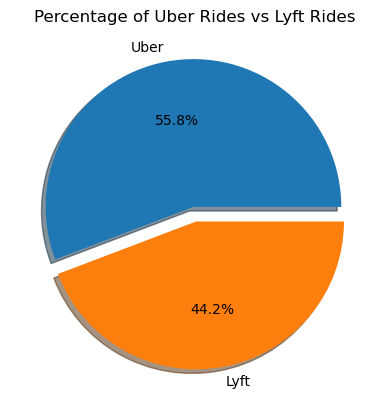

In [13]:
# Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()
percentages = (ride_counts / ride_counts.sum()) * 100

explode = [0.05] * len(percentages)

plt.pie(percentages, labels=percentages.index, explode=explode, shadow=True, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.show()

2.B How many rides were taken depending on distance travelled? Do people use Lyft or Uber more for longer distances?

In [14]:
# Find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


In [15]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
uber_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Uber Ride Count":ride_counts})
uber_ranges

Distance Range  Uber Ride Count
0      0-2 miles            67317
1      2-4 miles            63131
2      4-6 miles             8679
3      6-8 miles             1339

In [16]:
# Filter the DataFrame to include only Lyft rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Lyft rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
lyft_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Lyft Ride Count":ride_counts})
lyft_ranges

Distance Range  Lyft Ride Count
0      0-2 miles            51883
1      2-4 miles            51591
2      4-6 miles             7865
3      6-8 miles               22

In [17]:
# Merge data into a single table for easy plotting
range_df=pd.merge(uber_ranges,lyft_ranges, on="Distance Range", how="left")
range_df

Distance Range  Uber Ride Count  Lyft Ride Count
0      0-2 miles            67317            51883
1      2-4 miles            63131            51591
2      4-6 miles             8679             7865
3      6-8 miles             1339               22

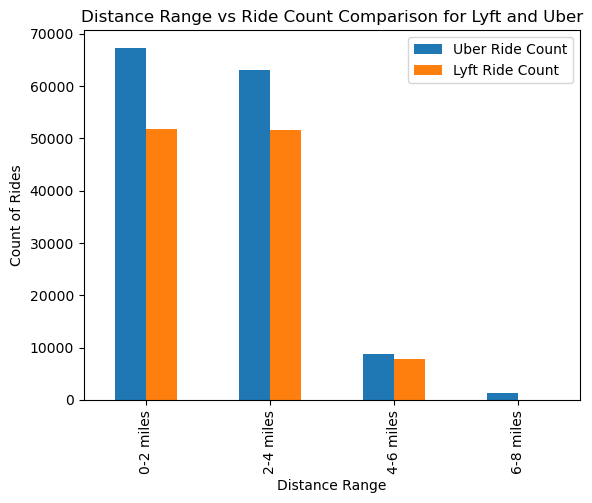

In [18]:
# Plotting a bar chart to show rides taken for various distance ranges per rideshare app
ax=range_df.plot.bar()
labels=range_df["Distance Range"]
ax.set_xticklabels(labels)
plt.title("Distance Range vs Ride Count Comparison for Lyft and Uber")
plt.xlabel("Distance Range")
plt.ylabel("Count of Rides")
plt.show()

2.C Knowing the number of rides taken for each rideshare app, how does this translate into overall revenue earned by Uber vs Lyft?

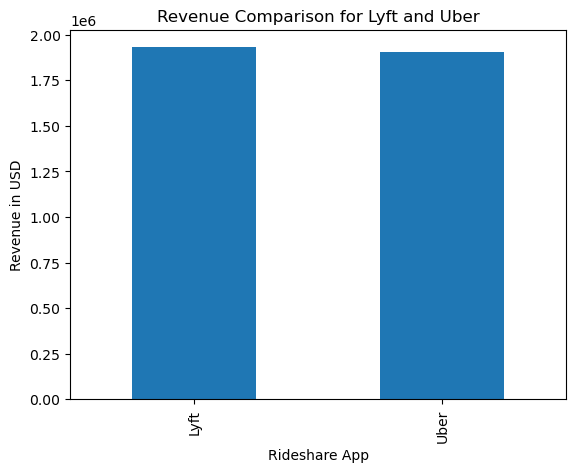

In [19]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()

#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()


In [20]:
# For a deeper dive, let's look at revenue per month for each rideshare app
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("Month")["Price($)"].sum()

uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["Month"])["Price($)"].sum()

# Create a Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

Lyft       Uber
Month                       
11     1126795.80  1117151.5
12      803659.35   785612.5

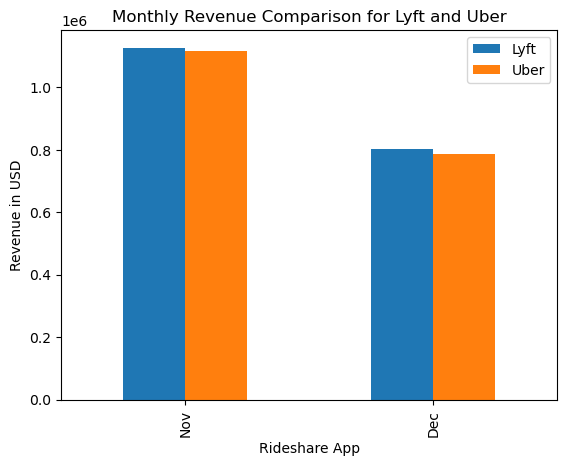

In [21]:
# Plotting a bar chart to show revenue based on month, per rideshare app
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

2.D At what time do people prefer to take an Uber vs. Lyft? Is there a behavioral trend that differentiates how people use these apps?

In [22]:
# In order to look at the number of rides taken per hour, we need to extract the information from the timestamps

final_df["Hour"]=final_df["Date"].dt.hour
final_df.head()

Date Weekday  Month         Pick_Up_Location  \
0 2018-11-26 03:40:46.318000128  Monday     11        Boston University   
1 2018-11-26 03:40:46.319000064  Monday     11         Theatre District   
2 2018-11-26 03:40:46.319000064  Monday     11            South Station   
3 2018-11-26 03:40:46.320000000  Monday     11         Theatre District   
4 2018-11-26 03:40:46.320000000  Monday     11  Northeastern University   

        Destination  Distance(m)  Price($)  Surge_Multiplier Rideshare_App  \
0  Theatre District         3.03      34.0               1.0          Lyft   
1         North End         1.57       0.0               1.0          Uber   
2  Theatre District         1.30      18.5               1.0          Uber   
3            Fenway         2.71      19.5               1.0          Uber   
4       Beacon Hill         2.43      10.5               1.0          Lyft   

      Ride_Type  Temp(C)  Cloudiness(%)  Pressure(MB)  Rainfall(in)  \
0  Lux Black XL    41.07           86.0       1014.39           0.0   
1          Taxi    40.80           87.0       1014.39           0.0   
2         Black    40.86           87.0       1014.39           0.0   
3         UberX    40.80           87.0       1014.39           0.0   
4          Lyft    40.81           89.0       1014.35           0.0   

   Humidity(%)  Wind_Speed(mph)  Hour  
0         92.0             1.36     3  
1         93.0             1.55     3  
2         93.0             1.60     3  
3         93.0             1.55     3  
4         93.0             1.36     3

In [23]:
# Let's find average number of Uber Rides taken per day and per hour

uber=final_df.loc[final_df["Rideshare_App"]=="Uber"]

grouped_hour_day = uber.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_uber = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_uber)

Hour  Weekday  
0     Friday        516.0
      Monday        644.0
      Saturday      475.0
      Sunday        501.0
      Thursday     2336.0
                    ...  
23    Saturday      529.0
      Sunday        844.0
      Thursday      489.0
      Tuesday       828.0
      Wednesday    2345.0
Length: 163, dtype: float64


In [24]:
# Let's find average number of Lyft Rides taken per day and per hour

lyft=final_df.loc[final_df["Rideshare_App"]=="Lyft"]

grouped_hour_day = lyft.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_lyft = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_lyft)

Hour  Weekday  
0     Friday        420.0
      Monday        436.0
      Saturday      461.0
      Sunday        435.0
      Thursday     1879.0
                    ...  
23    Saturday      407.0
      Sunday        681.0
      Thursday      447.0
      Tuesday       732.0
      Wednesday    1711.0
Length: 163, dtype: float64


In [25]:
# Defining a function that'll allow us to easily plot some timeseries graphs

def plot(dataframe):
# Create a list of weekdays to use as labels
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a figure and axis objects
    fig, ax = plt.subplots(figsize=(10,6))

# Iterate over each weekday and plot a line for the count of car rides
    for weekday in weekdays:
        data = dataframe.loc[dataframe.index.get_level_values('Weekday') == weekday]
        ax.plot(data.index.get_level_values('Hour'), data, label=weekday)


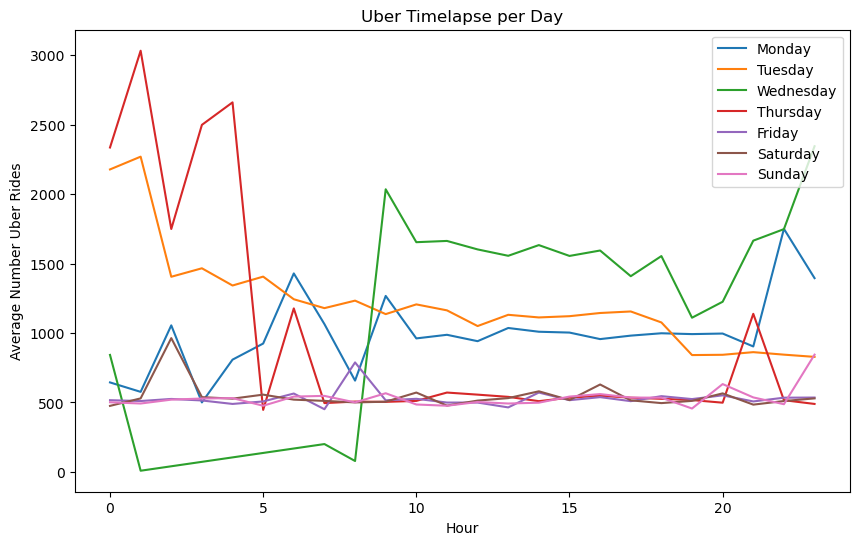

In [26]:
# Average Rides for Uber Timeseries
plot(mean_rides_uber)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Uber Rides')
plt.title("Uber Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.show()

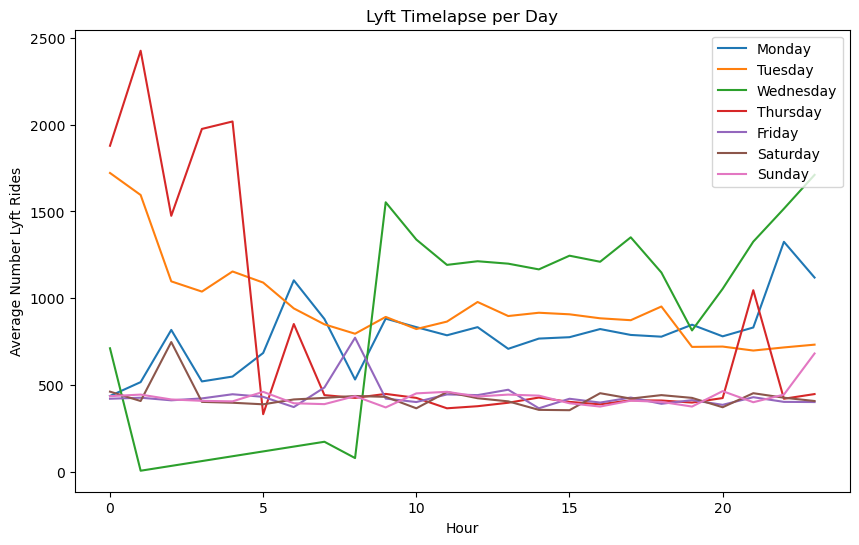

In [27]:
# Average Rides for Lyft Timeseries
plot(mean_rides_lyft)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Lyft Rides')
plt.title("Lyft Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.show()

2.E What Ride Types do people prefer across an average day?

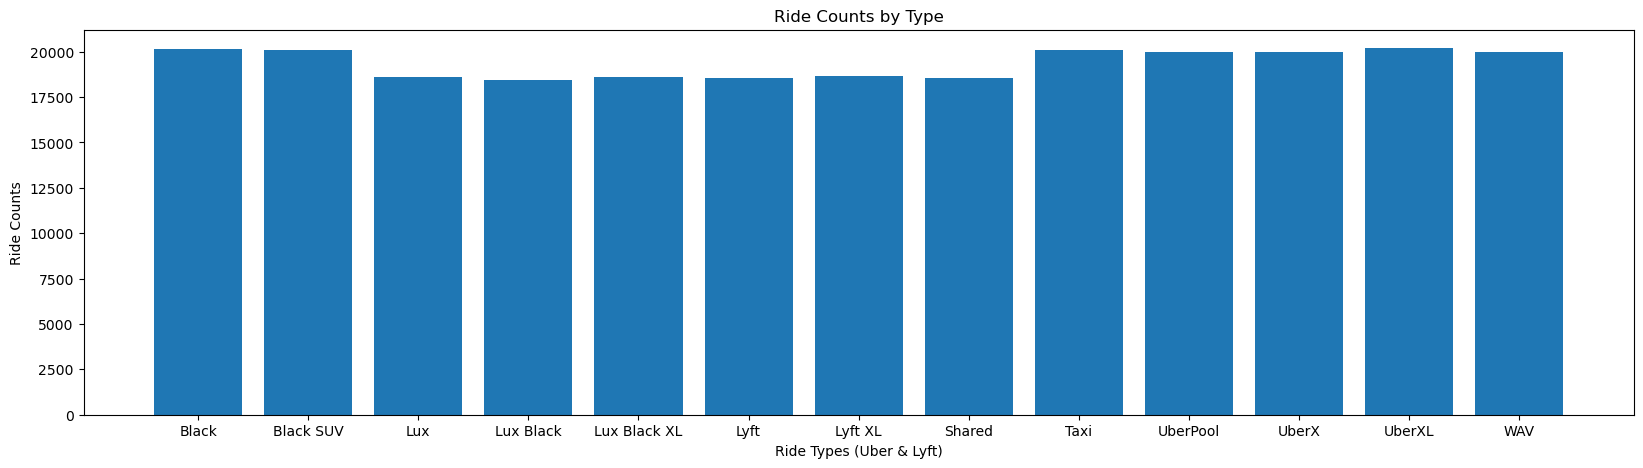

In [28]:
# Let's regroup our data to identify ride types for each app

grouped_data=final_df.groupby("Ride_Type")
ride_type_counts=grouped_data["Destination"].count()

plt.figure(figsize=(20,5))
plt.bar(ride_type_counts.index,height=ride_type_counts.values)
plt.xlabel("Ride Types (Uber & Lyft)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts by Type")
plt.show()

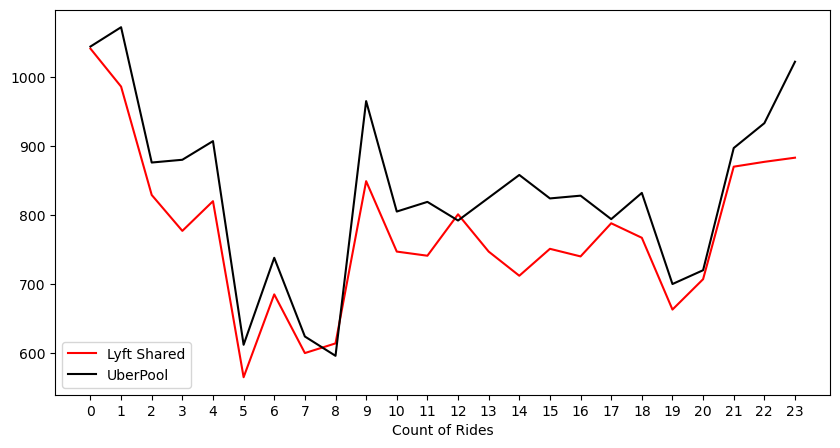

In [29]:
# Since there isn't a lot of variation of rides by ride type, let's compare the frequency of shared ride types Lyft Shared and UberPool

shared=final_df.loc[final_df["Ride_Type"]=="Shared"]
shared_count=shared.groupby("Hour")["Destination"].count()

uberpool=final_df.loc[final_df["Ride_Type"]=="UberPool"]
uberpool_count=uberpool.groupby("Hour")["Destination"].count()

plt.figure(figsize=(10,5))

plt.plot(shared_count.index,shared_count.values,c="red", label="Lyft Shared")
plt.plot(uberpool_count.index,uberpool_count.values,c="black", label="UberPool")
plt.xticks(shared_count.index)

plt.xlabel("Hour")
plt.xlabel("Count of Rides")
plt.legend()
plt.show()

## Part 3 - How are Car Rides Affected by Weather?
----
#### Weather plays a pivotal role in commute! In our given data, there are plausible elements of nature that could potentially affect how one gets from point A to point B. Now that we have a general idea of what app is preferable, let's add a second layer to the analyses.

3.A How do factors like rain, wind speed and cloudiness affect one's preference to use Rideshare Apps? Is one app used more than the other? Is the frequency of rides affected with worse weather conditions?

In [30]:
# In order to better visualize the amount of rainfall, we need to convert our unit of measurement to millimeters and also derive count of rides per day

final_df["Rainfall(mm)"]=final_df["Rainfall(in)"]*25.4
final_df["Date by hour"]=final_df["Date"].dt.strftime("%Y-%m-%d %H:%M")
day_grouped=final_df.groupby("Date by hour")

# Making a list of days in the given week. This will eventually be our x-axis
days_of_the_week=final_df["Date by hour"].unique()

# Splitting the edited dataframe by Rideshare App
uber_split = final_df.loc[final_df["Rideshare_App"]=="Uber"]
lyft_split = final_df.loc[final_df["Rideshare_App"]=="Lyft"]

In [31]:
# Finding out the count of rides taken per day of the week for Uber

uber_grouped=uber_split.groupby(["Date by hour"])
uber_ride_count=uber_grouped.count()["Destination"]
uber_ride_count.head()

Date by hour
2018-11-26 03:40    41
2018-11-26 04:40    52
2018-11-26 04:41    55
2018-11-26 04:43    50
2018-11-26 04:49    48
Name: Destination, dtype: int64

In [32]:
# Finding out the count of rides taken per day of the week for Uber

lyft_grouped=lyft_split.groupby(["Date by hour"])
lyft_ride_count=lyft_grouped.count()["Destination"]
lyft_ride_count.head()

Date by hour
2018-11-26 03:40    43
2018-11-26 04:40    32
2018-11-26 04:41    29
2018-11-26 04:43    34
2018-11-26 04:49    36
Name: Destination, dtype: int64

In [33]:
# Finding average rainfall each day

ave_rainfall=day_grouped.mean()["Rainfall(mm)"]
ave_rainfall.head()

Date by hour
2018-11-26 03:40    0.0
2018-11-26 04:40    0.0
2018-11-26 04:41    0.0
2018-11-26 04:43    0.0
2018-11-26 04:49    0.0
Name: Rainfall(mm), dtype: float64

In [34]:
# Finding average wind speed each day

ave_wind_speed=day_grouped.mean()["Wind_Speed(mph)"]
ave_wind_speed.head()

Date by hour
2018-11-26 03:40    1.485952
2018-11-26 04:40    2.584048
2018-11-26 04:41    2.595238
2018-11-26 04:43    2.641310
2018-11-26 04:49    2.611190
Name: Wind_Speed(mph), dtype: float64

In [35]:
# Finding average wind speed each day

ave_cloudiness=day_grouped.mean()["Cloudiness(%)"]
ave_cloudiness.head()

Date by hour
2018-11-26 03:40    87.309524
2018-11-26 04:40    86.452381
2018-11-26 04:41    86.428571
2018-11-26 04:43    85.892857
2018-11-26 04:49    94.511905
Name: Cloudiness(%), dtype: float64

In [36]:
# Create the final dataframe for plotting

rides_vs_weather = pd.DataFrame({"Uber Ride Count":uber_ride_count,"Lyft Ride Count":lyft_ride_count,"Average Rainfall (mm)":ave_rainfall,"Average Wind Speed (mph)":ave_wind_speed, "Average Cloudiness (%)":ave_cloudiness},index=days_of_the_week)
rides_vs_weather.head()

Uber Ride Count  Lyft Ride Count  Average Rainfall (mm)  \
2018-11-26 03:40             41.0             43.0                    0.0   
2018-11-26 04:40             52.0             32.0                    0.0   
2018-11-26 04:41             55.0             29.0                    0.0   
2018-11-26 04:43             50.0             34.0                    0.0   
2018-11-26 04:49             48.0             36.0                    0.0   

                  Average Wind Speed (mph)  Average Cloudiness (%)  
2018-11-26 03:40                  1.485952               87.309524  
2018-11-26 04:40                  2.584048               86.452381  
2018-11-26 04:41                  2.595238               86.428571  
2018-11-26 04:43                  2.641310               85.892857  
2018-11-26 04:49                  2.611190               94.511905

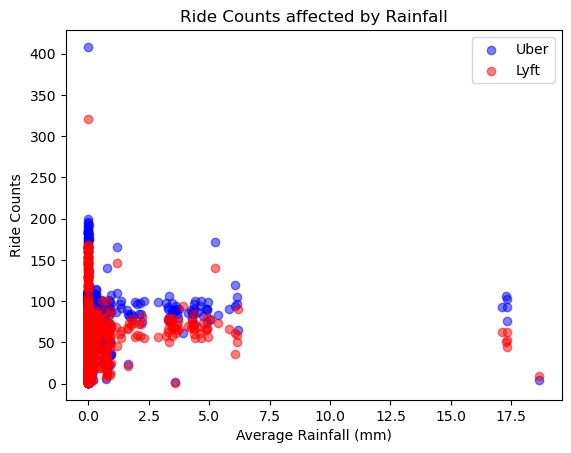

In [37]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Rainfall (mm)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Rainfall")
plt.show()

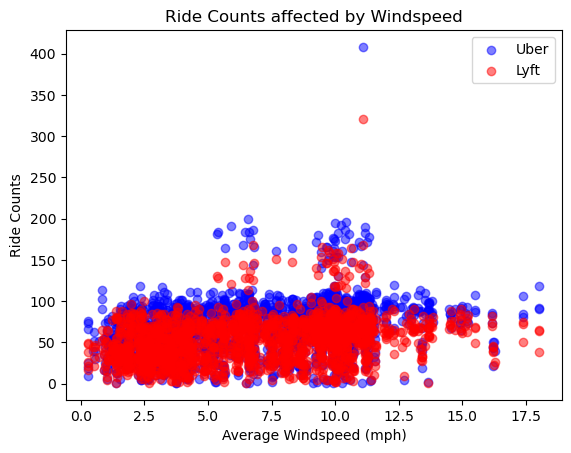

In [38]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Windspeed (mph)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Windspeed")
plt.show()

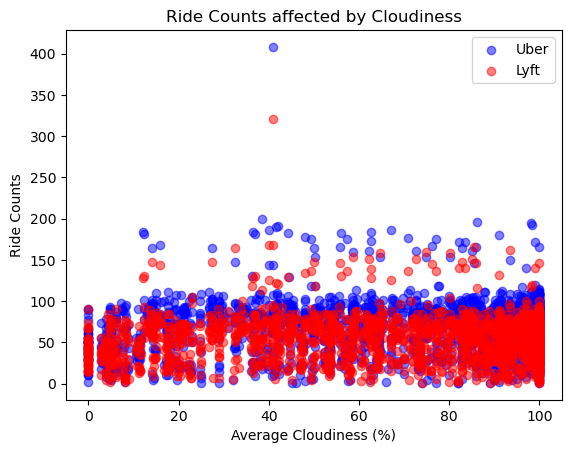

In [39]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Cloudiness (%)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Cloudiness")
plt.show()

In [40]:
#Analysis on how rain can effect the cab rides
rain_analysis = final_df[['Pick_Up_Location', 'Date', 'Rideshare_App',  "Rainfall(in)"]]
rain_analysis.isnull().sum()

Pick_Up_Location    0
Date                0
Rideshare_App       0
Rainfall(in)        0
dtype: int64

In [41]:
#Set the null values if there are any in the data set as 0 and consider it as no rainfall. 
rain_analysis["Rainfall(in)"].fillna(value=0)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
251822    0.0
251823    0.0
251824    0.0
251825    0.0
251826    0.0
Name: Rainfall(in), Length: 251827, dtype: float64

In [42]:
#check count of no rain fall vs rainfall days 
#Rainfall_mm = rain_analysis["Rainfall(in)"] * 25.4
rain_analysis["Rainfall_mm"]=rain_analysis["Rainfall(in)"] * 25.4
count_rain = rain_analysis.groupby(["Rainfall_mm"]).size().reset_index()
count_rain.columns=["Rainfall_mm", "count"]
print(count_rain)

     Rainfall_mm   count
0        0.00000  210883
1        0.00508      77
2        0.00762     126
3        0.01270      11
4        0.01524      37
..           ...     ...
418     18.40738      40
419     19.06270      71
420     19.36750      49
421     19.69262      61
422     19.82978      76

[423 rows x 2 columns]


<Axes: xlabel='Rainfall_mm', ylabel='count'>

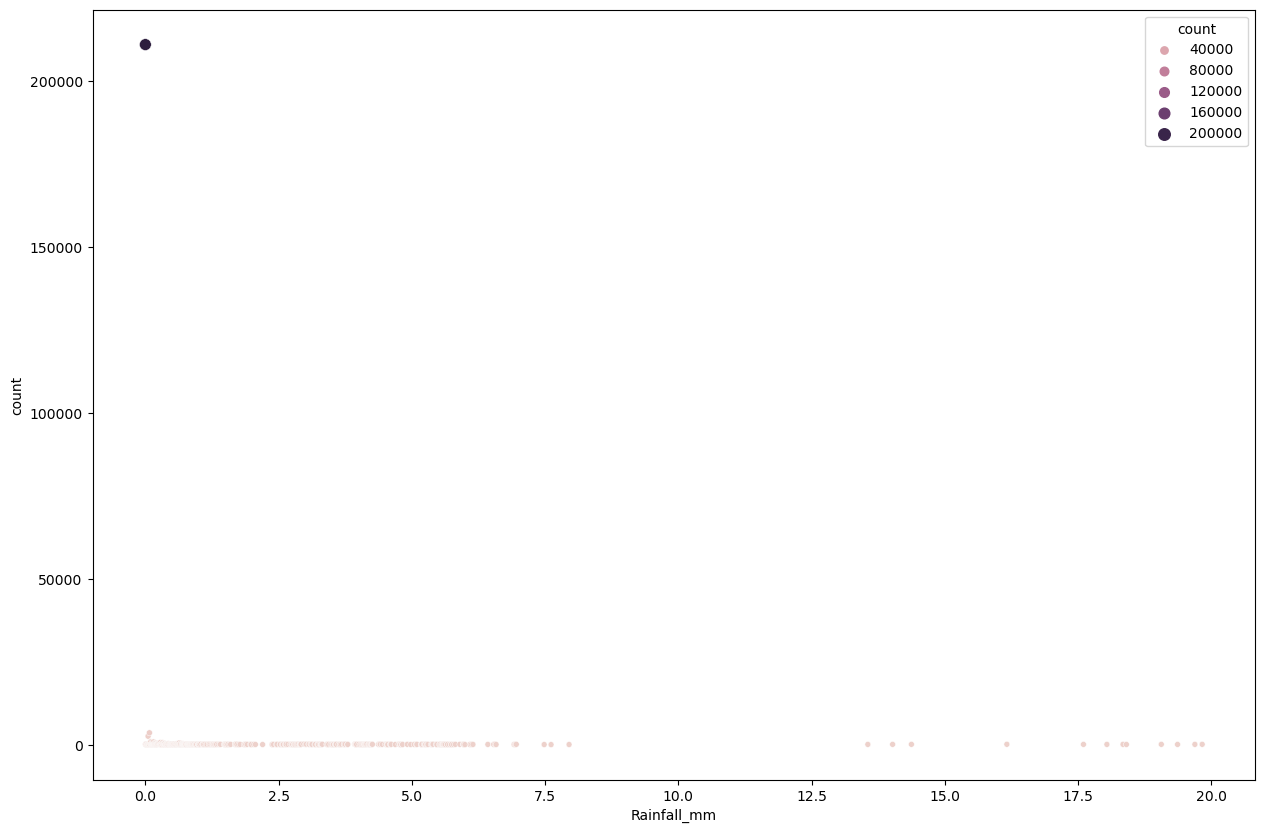

In [43]:
#Scatter plot to show number of rides when it rains vs no rain
plt.figure(figsize=(15, 10))
sns.scatterplot(data = count_rain, x = "Rainfall_mm", y="count", hue="count", size="count")

In [44]:
rain_analysis.head()

Pick_Up_Location                          Date Rideshare_App  \
0        Boston University 2018-11-26 03:40:46.318000128          Lyft   
1         Theatre District 2018-11-26 03:40:46.319000064          Uber   
2            South Station 2018-11-26 03:40:46.319000064          Uber   
3         Theatre District 2018-11-26 03:40:46.320000000          Uber   
4  Northeastern University 2018-11-26 03:40:46.320000000          Lyft   

   Rainfall(in)  Rainfall_mm  
0           0.0          0.0  
1           0.0          0.0  
2           0.0          0.0  
3           0.0          0.0  
4           0.0          0.0

Text(0.5, 1.0, 'Uber vs Lyft - Who gets more rides when it Rains')

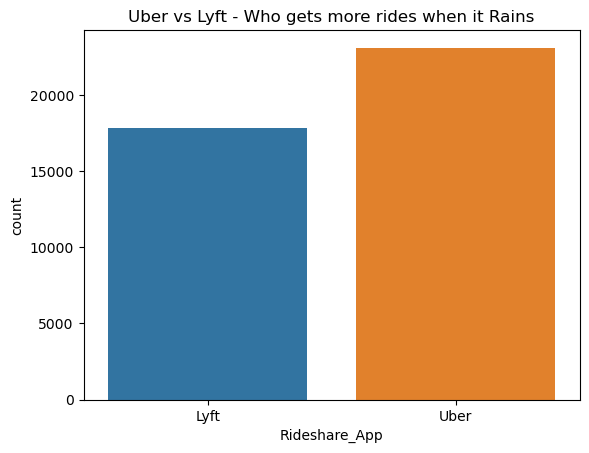

In [45]:
#Check on which company gets more rides when it rains. As per below analysis it looks like Uber gets more rides when it rains, but if we had more data then this gap would have reduced.
Rain = rain_analysis[rain_analysis["Rainfall(in)"]!= 0]
count_Rainfall = Rain.groupby(["Rideshare_App"]).size().reset_index()
count_Rainfall.columns = ["Rideshare_App","count"]
sns.barplot(x ="Rideshare_App", y="count", data=count_Rainfall).set_title("Uber vs Lyft - Who gets more rides when it Rains")

3.B Do these weather conditions affect how far people travel?

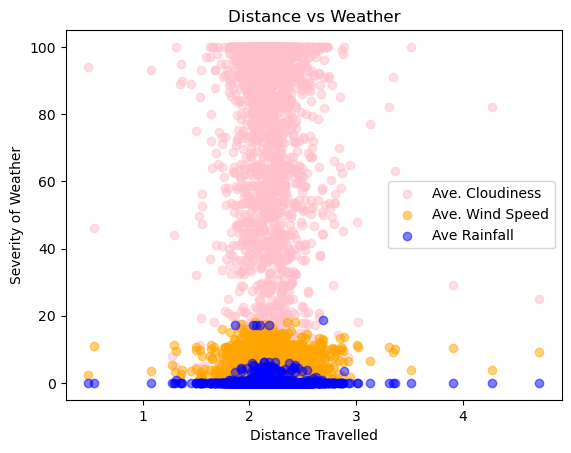

In [46]:
# Creating a scatter plot to show how distance travelled is related to different weather conditions, now assuming that Uber is the preferred app to use

ave_distance=day_grouped["Distance(m)"].mean()

plt.scatter(ave_distance,rides_vs_weather["Average Cloudiness (%)"], c="pink", alpha=0.5, label="Ave. Cloudiness")
plt.scatter(ave_distance,rides_vs_weather["Average Wind Speed (mph)"], c="orange", alpha=0.5, label="Ave. Wind Speed")
plt.scatter(ave_distance,rides_vs_weather["Average Rainfall (mm)"], c="blue", alpha=0.5, label="Ave Rainfall")

plt.xlabel("Distance Travelled")
plt.ylabel("Severity of Weather")
plt.title("Distance vs Weather")
plt.legend()
plt.show()

3.C
1. Correlation among All the Data in the DataFrame
2. Correlation among Weather condition and Price
3.  Correlation among Daily weather conditions and Revenue 

<Axes: >

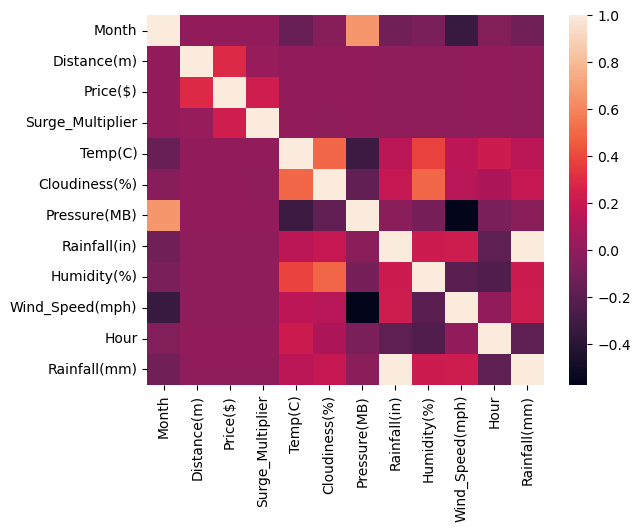

In [47]:
# Part 1 
#Plot the correlation heat map among numeric columns
# calculate the correlation matrix on the numeric columns
corr = final_df.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

<Axes: >

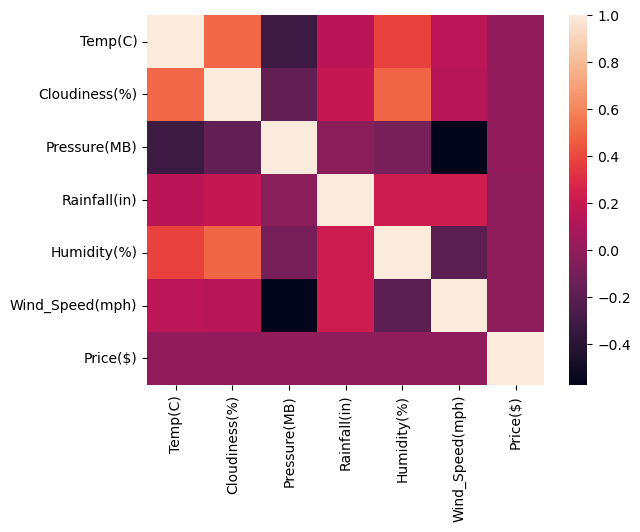

In [48]:
#Part 2
# calculate the correlation matrix on the wehater conditions and price
conditions_list = ["Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)","Price($)"]

corr = final_df.loc[:,conditions_list].select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

In [49]:
#Part 3
#aggregate the data to calculate the revenue and get the mean for the rest for each specific day 

#create a day field 
final_df["day"] = final_df["Date"].dt.date
by_date_df = final_df.groupby("day")
#create revenue and add a column called revenue to by_date dataframe

#aggregate the price column to get the revenue 
revenue = by_date_df["Price($)"].sum()
by_date_df = by_date_df.mean()
by_date_df["revenue"] = revenue

by_date_df


Month  Distance(m)   Price($)  Surge_Multiplier    Temp(C)  \
day                                                                      
2018-11-26   11.0     2.181645  15.190441          1.014115  42.988138   
2018-11-27   11.0     2.180381  15.208910          1.013726  43.298762   
2018-11-28   11.0     2.182835  15.161430          1.014051  38.346460   
2018-11-29   11.0     2.196001  15.251472          1.013658  38.831064   
2018-11-30   11.0     2.149066  15.120066          1.013158  35.559782   
2018-12-01   12.0     2.157073  15.128041          1.015121  36.748178   
2018-12-02   12.0     2.180121  15.350124          1.013047  42.261842   
2018-12-03   12.0     2.193667  15.273116          1.014283  48.960248   
2018-12-04   12.0     2.219436  15.347180          1.011989  43.821246   
2018-12-09   12.0     2.264805  15.286078          1.011885  30.700238   
2018-12-10   12.0     2.142010  14.953809          1.010737  29.019943   
2018-12-13   12.0     2.224984  15.416674          1.012980  25.309580   
2018-12-14   12.0     2.169070  15.198678          1.014440  33.911881   
2018-12-15   12.0     2.181230  15.215233          1.013844  46.126714   
2018-12-16   12.0     2.213894  15.444232          1.016913  41.123534   
2018-12-17   12.0     2.200746  15.186910          1.012778  38.453322   
2018-12-18   12.0     2.164751  15.135459          1.013327  30.453032   

            Cloudiness(%)  Pressure(MB)  Rainfall(in)  Humidity(%)  \
day                                                                  
2018-11-26      96.055672   1012.559447      0.008133    89.320221   
2018-11-27      89.073694    994.894073      0.050001    85.917980   
2018-11-28      63.501099    992.386267      0.000059    69.605919   
2018-11-29      53.264921   1000.500812      0.000099    67.573952   
2018-11-30      27.712972   1015.441737      0.000000    71.409919   
2018-12-01      64.079679   1020.960980      0.000060    70.354211   
2018-12-02      86.788410   1014.903412      0.008145    88.962874   
2018-12-03      76.575420   1000.759251      0.000481    80.972858   
2018-12-04      31.542384   1003.353793      0.000000    61.605201   
2018-12-09      20.302207   1022.803480      0.000000    57.108659   
2018-12-10      22.890600   1021.628209      0.000000    59.170989   
2018-12-13      39.151726   1031.418681      0.000000    57.381558   
2018-12-14      49.665806   1032.776461      0.000000    72.771360   
2018-12-15      82.845353   1022.582415      0.000007    83.157942   
2018-12-16      69.440449   1020.192888      0.010392    73.363361   
2018-12-17      93.236242   1004.186633      0.004000    85.248709   
2018-12-18      58.670040   1006.103360      0.001337    56.585245   

            Wind_Speed(mph)       Hour  Rainfall(mm)    revenue  
day                                                              
2018-11-26         4.893740  14.411712      0.206578  289226.00  
2018-11-27         9.886075  10.738256      1.270026  611915.30  
2018-11-28         8.655221  15.364044      0.001496  689511.50  
2018-11-29        10.265122   6.210804      0.002516  474031.00  
2018-11-30         3.827739  11.315705      0.000000  179263.50  
2018-12-01         3.415152  10.927106      0.001511  182837.50  
2018-12-02         3.855633  11.550594      0.206886  173241.50  
2018-12-03         5.639698  11.499778      0.012217  171624.00  
2018-12-04         7.815981   2.687606      0.000000   45443.00  
2018-12-09         5.535110  23.000000      0.000000    9003.50  
2018-12-10         4.804692   1.643436      0.000000   18453.00  
2018-12-13         3.313813  12.042029      0.000000  168365.50  
2018-12-14         3.018267  11.500623      0.000000  170772.35  
2018-12-15         5.490737  11.500000      0.000181  170897.50  
2018-12-16         8.258245  11.499288      0.263959  173500.50  
2018-12-17         9.357549  11.498486      0.101607  170549.00  
2018-12-18        13.235013   9.000000      0.033972  134584.50

<Axes: >

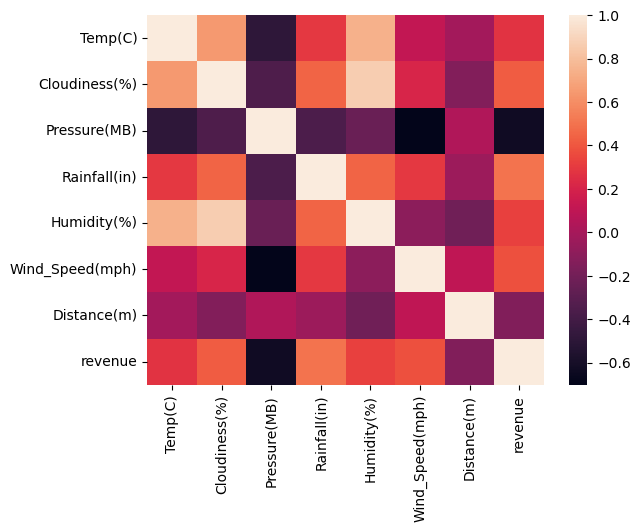

In [50]:
# calculate the correlation matrix on revenue based on the wehater conditions on specific days
conditions_list = ["Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)","Distance(m)","revenue"]

corr = by_date_df.loc[:,conditions_list].select_dtypes('number').corr()


# plot the heatmap
sns.heatmap(corr)

## Part 4 - Rideshare Behavior & Pricing
----
#### Next Part

4.A What does a summary analysis of pricing look like for our data?
    What is our outliers based on the price for each App?

In [51]:
#Generate a summary statistics of mean, median, variance, standard deviation, and SEM of the price for Lyft and Uber 

ride_app = final_df.groupby("Rideshare_App")

count_rides = ride_app["Price($)"].count()
mean_price = ride_app["Price($)"].mean()
median_price = ride_app["Price($)"].median()
var_price = ride_app["Price($)"].var()
std_price = ride_app["Price($)"].std()
sem_price = ride_app["Price($)"].sem()
min_price = ride_app["Price($)"].min()
max_price = ride_app["Price($)"].max()
price_rideApp_df = pd.DataFrame({"Price Mean":mean_price , 
                            "Price Median ":median_price,
                             "Price Variance":var_price,
                             "Price Std. Dev.":std_price,
                             "Price Std. Err.":sem_price,
                                "Total rides" :count_rides,
                                "Max Price" : max_price,
                                "Min Price": min_price})

price_rideApp_df

Price Mean  Price Median   Price Variance  Price Std. Dev.  \
Rideshare_App                                                               
Lyft            17.335110           16.5      100.338586        10.016915   
Uber            13.546082           11.0       93.315272         9.659983   

               Price Std. Err.  Total rides  Max Price  Min Price  
Rideshare_App                                                      
Lyft                  0.030017       111361       92.0        2.5  
Uber                  0.025775       140466       89.5        0.0

In [52]:
# create rides into list for loop
ride_list = ["Lyft", "Uber"]

#Create empty list to fill with price data (for plotting)
price_list =[]

for ride in ride_list:
    
    price = final_df[ final_df["Rideshare_App"]==ride]["Price($)"] 
    
    price_list.append(price)
    
    # Determine outliers using upper and lower bounds
    quartiles = price.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    # print if the counter is empty and add a space between each regimen
    
   
    print(f"The IQR data for {ride} is:")
    print(f"The lower quartile of {ride} is: {lowerq}")
    print(f"The upper quartile of {ride} is: {upperq}")
    print(f"The interquartile range of {ride} is: {iqr}")
    print(f"The the median of {ride} is: {quartiles[0.5]}")
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"")
   

The IQR data for Lyft is:
The lower quartile of Lyft is: 9.0
The upper quartile of Lyft is: 22.5
The interquartile range of Lyft is: 13.5
The the median of Lyft is: 16.5
Values below -11.25 could be outliers.
Values above 42.75 could be outliers.

The IQR data for Uber is:
The lower quartile of Uber is: 7.5
The upper quartile of Uber is: 19.0
The interquartile range of Uber is: 11.5
The the median of Uber is: 11.0
Values below -9.75 could be outliers.
Values above 36.25 could be outliers.



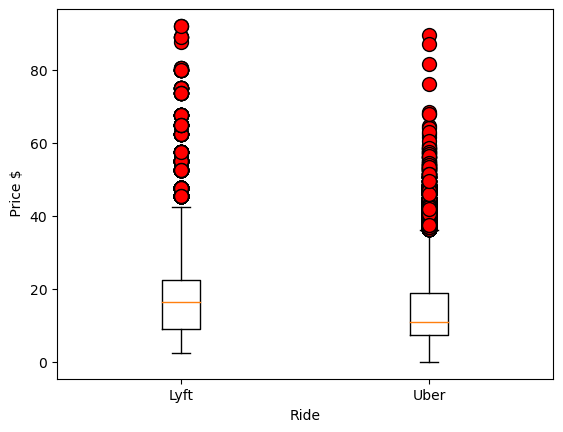

In [53]:
# Generate a box plot that shows the distrubution of the price based on each ride app.
flierprops = dict(marker='o', markerfacecolor='r', markersize=10, markeredgecolor='black')

fig1, ax1 = plt.subplots()
ax1.set_ylabel(" Price $")
ax1.set_xlabel("Ride")
ax1.boxplot(price_list, flierprops=flierprops)
ax1.set_xticklabels(ride_list)

plt.show()

<Axes: xlabel='Rideshare_App', ylabel='Price($)'>

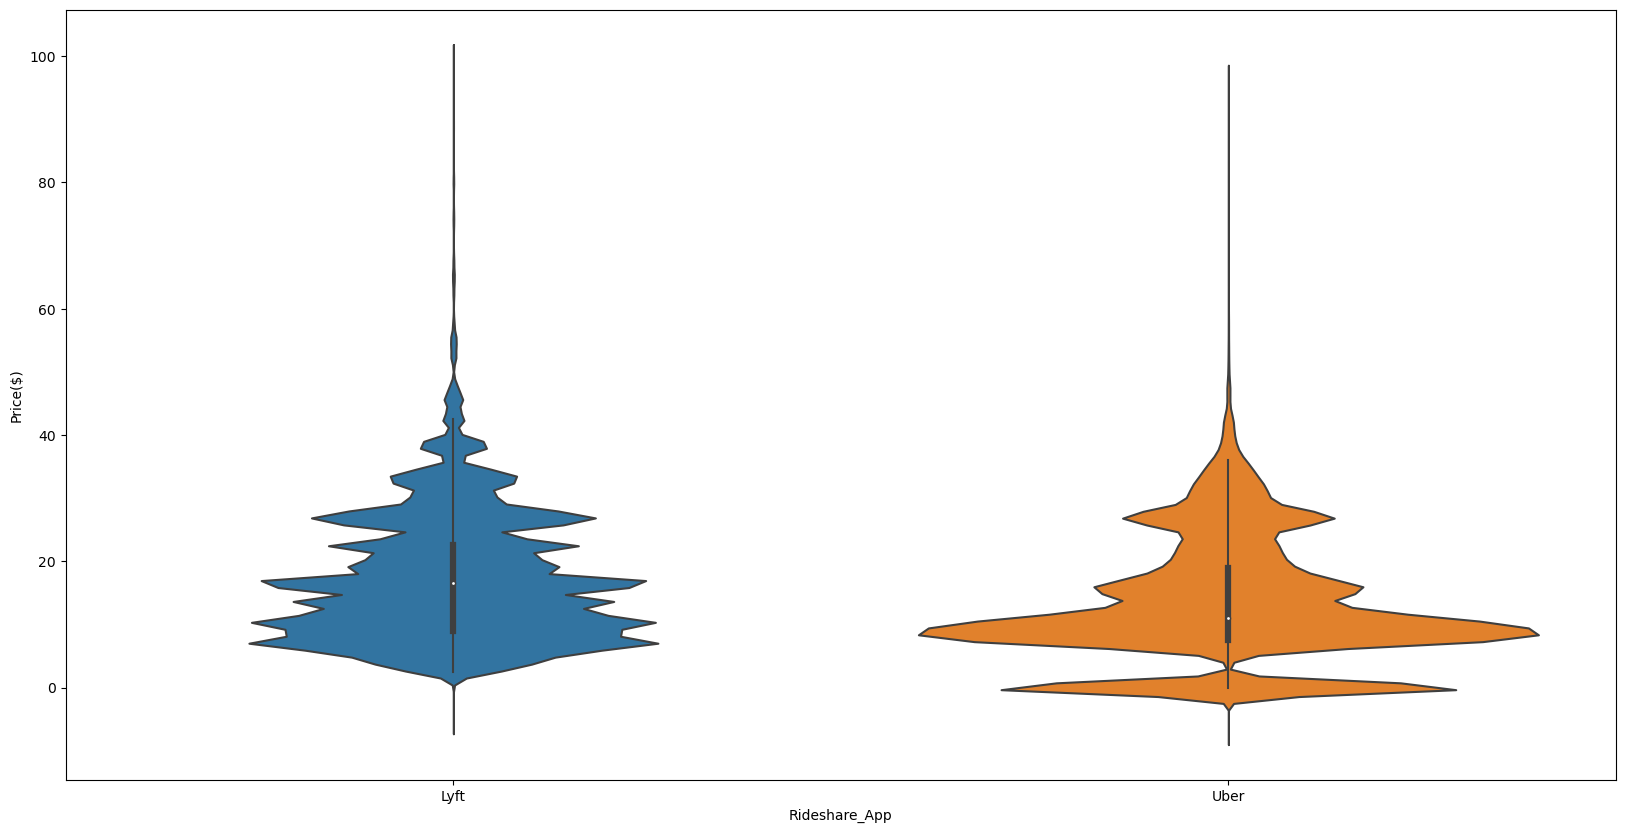

In [54]:
#Ride_share vs Price violin plot
plt.figure(figsize=(20, 10))
sns.violinplot(data=final_df, x='Rideshare_App', y='Price($)', gridsize=100, cut=10)

4.B How do prices change depending on the day of the week?

In [55]:
# Create a sorted list of days

days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [56]:
# Since we have previously split our final data frame into separate rideshare apps, we can find the average price of rides for each app on a given day of the week
# For Lyft
lyft_price = lyft_split.groupby(["Weekday"])["Price($)"].mean().reindex(days)
lyft_price

Weekday
Monday       17.301735
Tuesday      17.312292
Wednesday    17.251150
Thursday     17.424526
Friday       17.288538
Saturday     17.219977
Sunday       17.609578
Name: Price($), dtype: float64

In [57]:
# For Uber
uber_price = uber_split.groupby(["Weekday"])["Price($)"].mean().reindex(days)
uber_price

Weekday
Monday       13.540345
Tuesday      13.556304
Wednesday    13.520725
Thursday     13.599944
Friday       13.414310
Saturday     13.557390
Sunday       13.604709
Name: Price($), dtype: float64

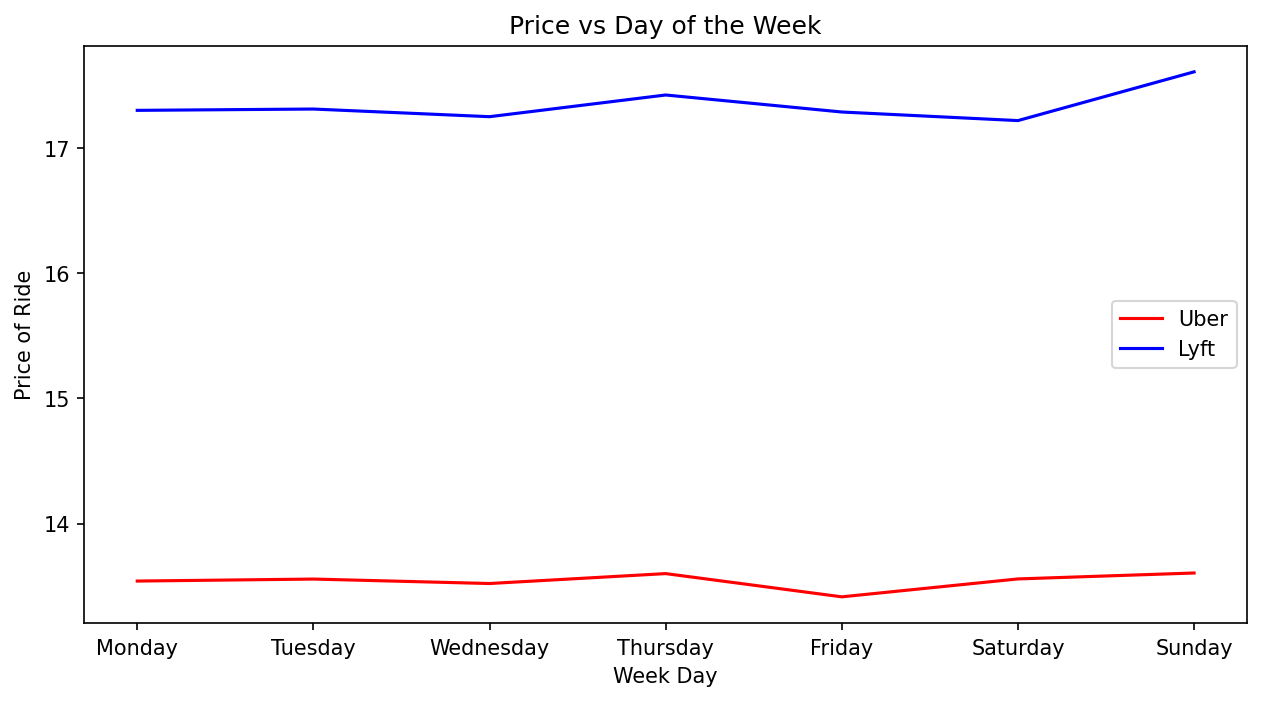

In [58]:
# Creating a line chart to observe the daily distribution of pricing per Rideshare App

plt.figure(figsize=(10, 5), dpi=150)
uber_price.plot(color ="r", label ="Uber")
lyft_price.plot(color ="b", label ="Lyft")

plt.xlabel("Week Day")
plt.ylabel("Price of Ride")
plt.title("Price vs Day of the Week") 
plt.legend()
plt.show()


4.C We now know that Lyft on average charges more per ride than Uber, but how does the ride to distance relationship work? How is pricing stipulated?

In [59]:
# Binning the distance
bins = [0,1,2,3,4,5,6,7,8]
uber_split["dist"] =  pd.cut(final_df["Distance(m)"].astype(float),bins)
lyft_split["dist"] =  pd.cut(final_df["Distance(m)"].astype(float),bins)

In [60]:
# Calculate the correlation coefficient and a linear regression model for price and distance based on the app used
# For Uber and Lyft

uber_dist=uber_split.groupby("dist").mean()
lyft_dist=lyft_split.groupby("dist").mean()
lyft_dist=lyft_dist.dropna()

# Count the number of Lyft rides within each distance range

uber_prices = uber_dist["Price($)"]
uber_distance = uber_dist["Distance(m)"]
lyft_prices = lyft_dist["Price($)"]
lyft_distance = lyft_dist["Distance(m)"]

corr_uber = round(st.pearsonr(uber_distance, uber_prices)[0],2)
corr_lyft = round(st.pearsonr(lyft_distance, lyft_prices)[0],2)
print(f"The correlation between price of Uber rides and the Distance {corr_uber}")
print(f"The correlation between price of Lyft rides and the Distance {corr_lyft}")

# Plotting linear regression graph
linear_reg_uber = st.linregress(uber_distance,uber_prices)
linear_reg_lyft = st.linregress(lyft_distance,lyft_prices)

The correlation between price of Uber rides and the Distance 0.98
The correlation between price of Lyft rides and the Distance 1.0


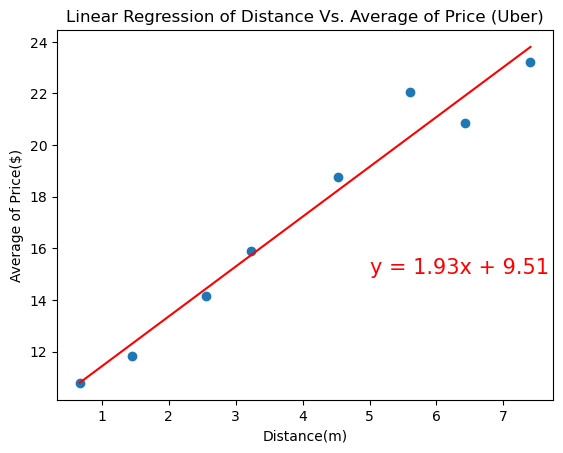

In [61]:
# Plot the regression line on the scatter plot for Uber

plt.scatter(uber_distance, uber_prices)

uber_price_predict = uber_distance * linear_reg_uber.slope + linear_reg_uber.intercept
plt.plot(uber_distance, uber_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg_uber.slope,2)) + "x + " + str(round(linear_reg_uber.intercept,2))
plt.annotate(line_eq,(5,15),fontsize=15,color="red")

plt.title("Linear Regression of Distance Vs. Average of Price (Uber)")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.show()

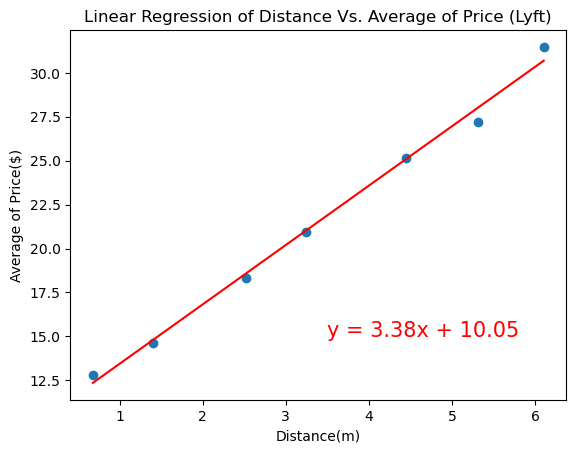

In [62]:
# Plot the regression line on the scatter plot for Lyft

plt.scatter(lyft_distance, lyft_prices)

lyft_price_predict = lyft_distance * linear_reg_lyft.slope + linear_reg_lyft.intercept
plt.plot(lyft_distance, lyft_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg_lyft.slope,2)) + "x + " + str(round(linear_reg_lyft.intercept,2))
plt.annotate(line_eq,(3.5,15),fontsize=15,color="red")

plt.title("Linear Regression of Distance Vs. Average of Price (Lyft)")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.show()

[Text(0.5, 0, 'Cab Type'), Text(0, 0.5, 'Number of cab')]

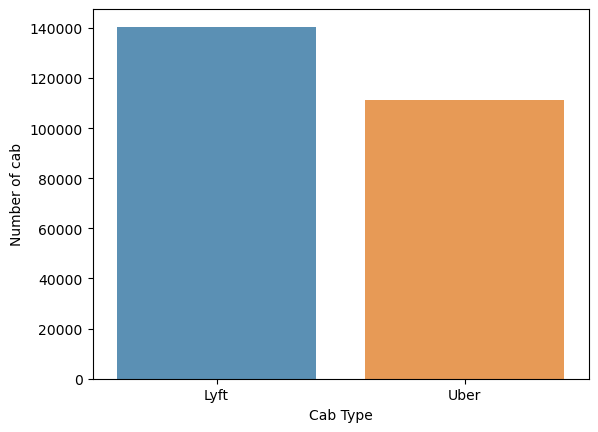

In [63]:
#Analysis to find Price vs distcance chart
# Explanation - Used Pie chart to find who gets more rides. 
# Explantion - Used Scatter plot to show general price vs distance chart, I dropped taxi from the data set as it contains 0 value for Uber cabs.
#based on the color combinations I want to figure out who has lower minimum fare based on the distance covered. 
Count = [final_df.Rideshare_App[(final_df.Rideshare_App)=='Uber'].count(),\
     final_df.Rideshare_App[(final_df.Rideshare_App)=='Lyft'].count()]
vis1= sns.barplot(x=final_df["Rideshare_App"].unique(), y=Count, alpha=0.8)
vis1.set(xlabel='Cab Type',ylabel='Number of cab')

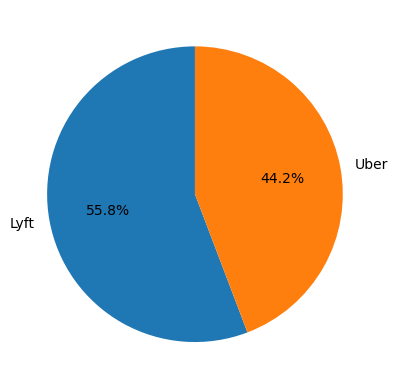

In [64]:
#Pie Chart
for p in vis1.patches:
             vis1.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
        
        
Ncab_type = [final_df.Rideshare_App[(final_df.Rideshare_App)=='Uber'].count(),\
             final_df.Rideshare_App[(final_df.Rideshare_App)=='Lyft'].count()]

plt.pie(Ncab_type, labels=final_df["Rideshare_App"].unique(), startangle=90, autopct='%.1f%%')

plt.show()

<Axes: xlabel='Distance(m)', ylabel='Price($)'>

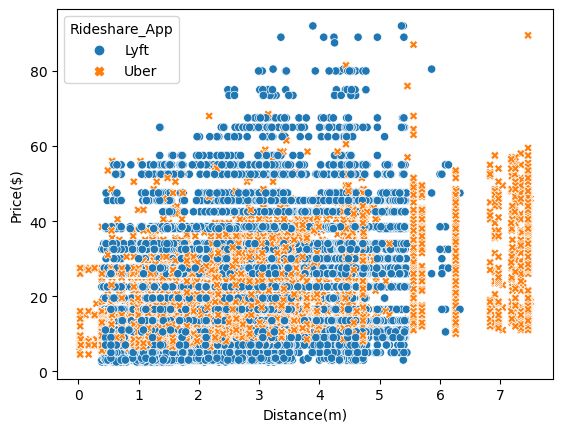

In [65]:
# Scatter Plot
Taxi=final_df[final_df.Ride_Type == 'Taxi'].index
final_df.drop(Taxi , inplace=True)
sns.scatterplot(x="Distance(m)", y="Price($)", data=final_df, hue="Rideshare_App",style="Rideshare_App", legend='full')

How the surge multiplier effects the prices for uber and lyft ? 

In [66]:
#Analysis on Surge Multiplier 
Surge_Lyft=final_df[final_df.Rideshare_App == 'Lyft']
Surge_Uber=final_df[final_df.Rideshare_App == 'Uber']
uber_df = final_df[final_df["Ride_Type"] == "Uber"]
lyft_df = final_df[final_df["Ride_Type"] == "Lyft"]
lyft_df["Surge_Multiplier"].value_counts()

1.00    17026
1.25      784
1.50      367
1.75      169
2.00      155
2.50       30
3.00        3
Name: Surge_Multiplier, dtype: int64

Text(0.5, 1.0, 'Weekday wise Surge')

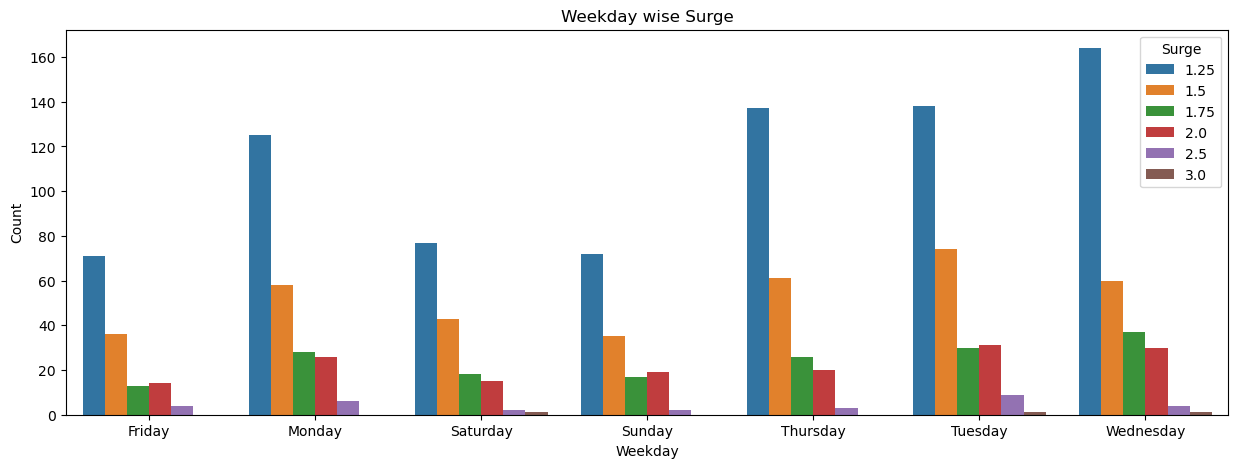

In [67]:
#considering only Surge that is greater than 1
#Explanation- Surge is observed mostly on Wednesday.3.0 surge is very less occuring surge. 
high_surge_dataset = lyft_df[lyft_df["Surge_Multiplier"]> 1]
t_high_surge = pd.DataFrame(high_surge_dataset.groupby(["Weekday", "Surge_Multiplier"]).size().reset_index())
t_high_surge.columns = ["Weekday", "Surge", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(x="Weekday", y="Count", hue="Surge", data=t_high_surge).set_title("Weekday wise Surge")

Analysing surge multiplier based on different time of the day

Text(0.5, 1.0, 'Time of Day wise Surge')

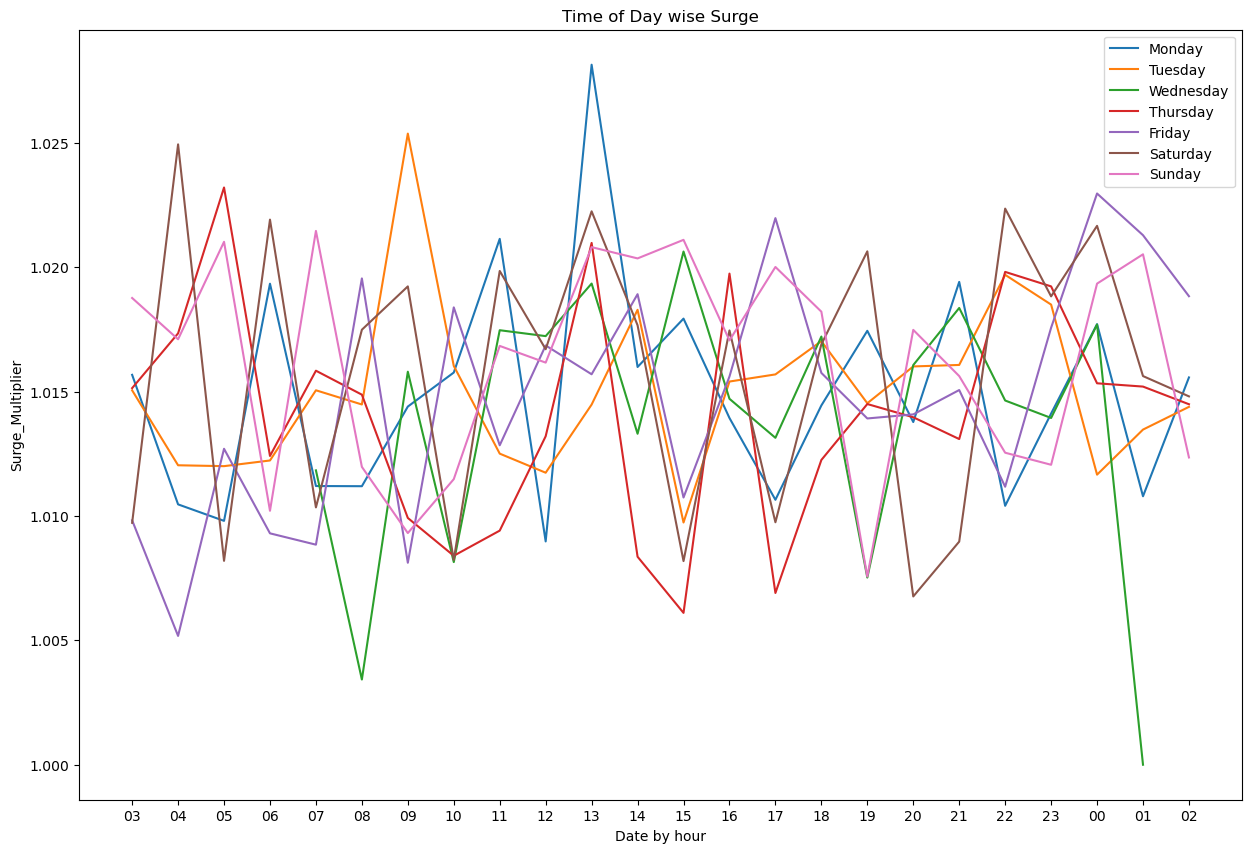

In [68]:
# Time of the day Surge 
df = pd.DataFrame({'date': pd.date_range('2018-07-02 10:54:00', periods=5)})
final_df['Day'] = pd.to_datetime(final_df['Date']).dt.date
#final_df['Time'] = pd.to_datetime(final_df['Date']).dt.time
final_df["Date by hour"]=final_df["Date"].dt.strftime("%H")
#print(final_df)
td_high_surge = pd.DataFrame(final_df.groupby(["Weekday", "Surge_Multiplier","Date by hour"]).size().reset_index())
td_high_surge.columns = ["Weekday", "Surge", "Date by hour", "Count"]
plt.figure(figsize=(15, 10))
#[final_df.Rideshare_App[(final_df.Rideshare_App)=='Uber'],
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Monday'],label = 'Monday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Tuesday'],label = 'Tuesday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Wednesday'],label = 'Wednesday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Thursday'],label = 'Thursday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Friday'],label = 'Friday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Saturday'],label = 'Saturday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Sunday'],label = 'Sunday', data=final_df, ci=None).set_title("Time of Day wise Surge")

4.D what is the relationship among price and ride types? Do we have outliers in our data? 


In [69]:
st

<module 'scipy.stats' from 'C:\\Users\\marya\\anaconda3\\lib\\site-packages\\scipy\\stats\\__init__.py'>

In [73]:
# calculate: MEAN, MEDIAN, MODE, VARIANCE, STANDARD DEVIATION
# Unique car types
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Calculate the values for each ride type
results = {}
for car_type in unique_car_types:
    # Filter the dataframe by ride type
    filtered_df = final_df[final_df['Ride_Type'] == car_type]
    
    # Calculate mean
    mean = np.mean(filtered_df['Price($)'])
    
    # Calculate median
    median = np.median(filtered_df['Price($)'])
    
    # Calculate mode
    mode = st.mode(filtered_df['Price($)'])
    
    # Calculate variance
    variance = np.var(filtered_df['Price($)'])
    
    # Calculate standard deviation
    std_dev = np.std(filtered_df['Price($)'])
    
    # Store the results
    results[car_type] = {'Mean': mean, 'Median': median, 'Mode': mode[0], 'Variance': variance, 'Standard Deviation': std_dev}

# Print the results
for car_type, stats in results.items():
    print(f"Ride Type: {car_type}")
    print(f"Mean: {stats['Mean']}")
    print(f"Median: {stats['Median']}")
    print(f"Mode: {stats['Mode']}")
    print(f"Variance: {stats['Variance']}")
    print(f"Standard Deviation: {stats['Standard Deviation']}")
    print()

Ride Type: UberX
Mean: 9.779783935180554
Median: 9.5
Mode: [9.5]
Variance: 6.255946217195363
Standard Deviation: 2.5011889607135567

Ride Type: UberXL
Mean: 15.670520374313016
Median: 15.0
Mode: [15.]
Variance: 20.684172294442735
Standard Deviation: 4.547985520474173

Ride Type: UberPool
Mean: 8.735811250814006
Median: 8.5
Mode: [7.5]
Variance: 4.417405627250317
Standard Deviation: 2.101762504958711

Ride Type: WAV
Mean: 9.788538538538539
Median: 9.5
Mode: [9.5]
Variance: 6.327080847113403
Standard Deviation: 2.5153689286292384

Ride Type: Shared
Mean: 6.021713362068965
Median: 7.0
Mode: [7.]
Variance: 4.41555762473534
Standard Deviation: 2.101322827348368

Ride Type: Black
Mean: 20.516024844720498
Median: 19.5
Mode: [16.]
Variance: 24.825792893800696
Standard Deviation: 4.982548835064308

Ride Type: Black SUV
Mean: 30.229076532895718
Median: 28.5
Mode: [27.5]
Variance: 23.338654779016686
Standard Deviation: 4.831009705953475

Ride Type: Lyft XL
Mean: 15.311472859901308
Median: 13.5
Mo

In [76]:
#calculate MEAN, MEDIAN, MODE, VARIANCE, STANDARD DEVIATION --> & add 68-95-99.7 RULE , QUARTILES
from scipy import stats

# Unique car types
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Calculate the values for each ride type
results = {}
for car_type in unique_car_types:
    # Filter the dataframe by ride type
    filtered_df = final_df[final_df['Ride_Type'] == car_type]
    
    # Calculate mean
    mean = np.mean(filtered_df['Price($)'])
    
    # Calculate median
    median = np.median(filtered_df['Price($)'])
    
    # Calculate mode
    mode = st.mode(filtered_df['Price($)'])
    
    # Calculate variance
    variance = np.var(filtered_df['Price($)'])
    
    # Calculate standard deviation
    std_dev = np.std(filtered_df['Price($)'])
    
    # Calculate 68-95-99.7 rule values
    lower_bound_68 = mean - std_dev
    upper_bound_68 = mean + std_dev
    
    lower_bound_95 = mean - 2 * std_dev
    upper_bound_95 = mean + 2 * std_dev
    
    lower_bound_99 = mean - 3 * std_dev
    upper_bound_99 = mean + 3 * std_dev
    
    # Calculate quartiles
    quartiles = filtered_df['Price($)'].quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    
    # Calculate Z-score
    z_scores = st.zscore(filtered_df['Price($)'])
    
    # Store the results
    results[car_type] = {
        'Mean': mean,
        'Median': median,
        'Mode': mode[0],
        'Variance': variance,
        'Standard Deviation': std_dev,
        'Lower Bound 68': lower_bound_68,
        'Upper Bound 68': upper_bound_68,
        'Lower Bound 95': lower_bound_95,
        'Upper Bound 95': upper_bound_95,
        'Lower Bound 99': lower_bound_99,
        'Upper Bound 99': upper_bound_99,
        'Lower Quartile': lowerq,
        'Upper Quartile': upperq,
        'IQR': iqr,
        'Z-Scores': z_scores
    }

# Print the results
for car_type, stats in results.items():
    print(f"Ride Type: {car_type}")
    print(f"Mean: {stats['Mean']}")
    print(f"Median: {stats['Median']}")
    print(f"Mode: {stats['Mode']}")
    print(f"Variance: {stats['Variance']}")
    print(f"Standard Deviation: {stats['Standard Deviation']}")
    print(f"Lower Quartile-25%: {stats['Lower Quartile']}")
    print(f"Upper Quartile-75%: {stats['Upper Quartile']}")
    print(f"IQR-Upper Quartile minus Lower Quartile: {stats['IQR']}")
    print(f"Lower Bound (68%): {stats['Lower Bound 68']}")
    print(f"Upper Bound (68%): {stats['Upper Bound 68']}")
    print(f"Lower Bound (95%): {stats['Lower Bound 95']}")
    print(f"Upper Bound (95%): {stats['Upper Bound 95']}")
    print(f"Lower Bound (99%): {stats['Lower Bound 99']}")
    print(f"Upper Bound (99%): {stats['Upper Bound 99']}")
    print("68-95-99.7 Rule:")
    print(f"Roughly 68% of the Data is between {stats['Lower Bound 68']} and {stats['Upper Bound 68']}")
    print(f"Roughly 95% of the Data is between {stats['Lower Bound 95']} and {stats['Upper Bound 95']}")
    print(f"Roughly 99.7% of the Data is between {stats['Lower Bound 99']} and {stats['Upper Bound 99']}")
    print()

Ride Type: UberX
Mean: 9.779783935180554
Median: 9.5
Mode: [9.5]
Variance: 6.255946217195363
Standard Deviation: 2.5011889607135567
Lower Quartile-25%: 8.0
Upper Quartile-75%: 10.5
IQR-Upper Quartile minus Lower Quartile: 2.5
Lower Bound (68%): 7.278594974466997
Upper Bound (68%): 12.28097289589411
Lower Bound (95%): 4.77740601375344
Upper Bound (95%): 14.782161856607667
Lower Bound (99%): 2.2762170530398835
Upper Bound (99%): 17.283350817321224
68-95-99.7 Rule:
Roughly 68% of the Data is between 7.278594974466997 and 12.28097289589411
Roughly 95% of the Data is between 4.77740601375344 and 14.782161856607667
Roughly 99.7% of the Data is between 2.2762170530398835 and 17.283350817321224

Ride Type: UberXL
Mean: 15.670520374313016
Median: 15.0
Mode: [15.]
Variance: 20.684172294442735
Standard Deviation: 4.547985520474173
Lower Quartile-25%: 12.5
Upper Quartile-75%: 17.5
IQR-Upper Quartile minus Lower Quartile: 5.0
Lower Bound (68%): 11.122534853838843
Upper Bound (68%): 20.2185058947871

In [ ]:
# Price Distribution by Car Type, BOX & WHISKER
# Step 1: Reference each unique car type
unique_car_types = [ 'UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Step 2: Collect prices for each unique car type
car_type_prices = []
for car_type in unique_car_types:
    prices = final_df.loc[final_df['Ride_Type'] == car_type, 'Price($)']
    car_type_prices.append(prices)

# Step 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_prices, labels=unique_car_types)
plt.title('Price Distribution by Car Type - No Data Manipulation')
plt.xlabel('Car Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

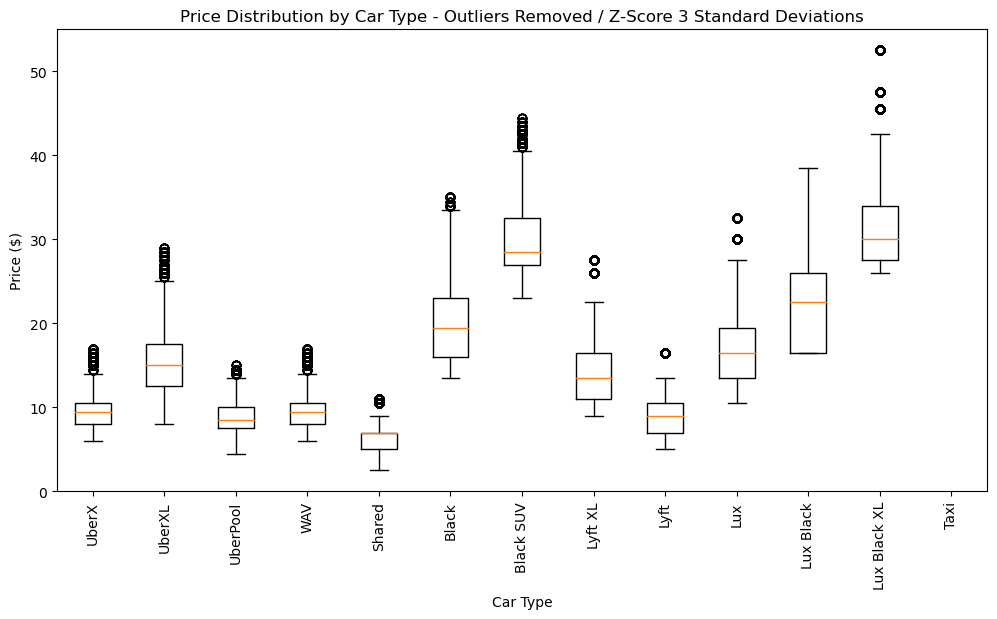

Median price for Lux Black XL: 30.0
Median price for Black SUV: 28.5
Median price for Lux Black: 22.5
Median price for Black: 19.5
Median price for Lux: 16.5
Median price for UberXL: 15.0
Median price for Lyft XL: 13.5
Median price for UberX: 9.5
Median price for WAV: 9.5
Median price for Lyft: 9.0
Median price for UberPool: 8.5
Median price for Shared: 7.0
Median price for Taxi: nan


In [77]:
# Price Distribution by Car Type, BOX & WHISKER / Z-SCORE, Outliers removed

# 1. Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2. Collect prices for each unique car type
car_type_prices = []
for car_type in unique_car_types:
    prices = final_df.loc[final_df['Ride_Type'] == car_type, 'Price($)']

    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    car_type_prices.append(filtered_prices)

# 3. Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_prices, labels=unique_car_types)
plt.title('Price Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Car Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

# Calculate and print the sorted median prices
median_prices = {car_type: np.median(prices) for car_type, prices in zip(unique_car_types, car_type_prices)}
sorted_median_prices = sorted(median_prices.items(), key=lambda x: x[1], reverse=True)

# Print the sorted median prices
for car_type, median_price in sorted_median_prices:
    print(f"Median price for {car_type}: {median_price}")

<Axes: xlabel='Ride_Type', ylabel='Price($)'>

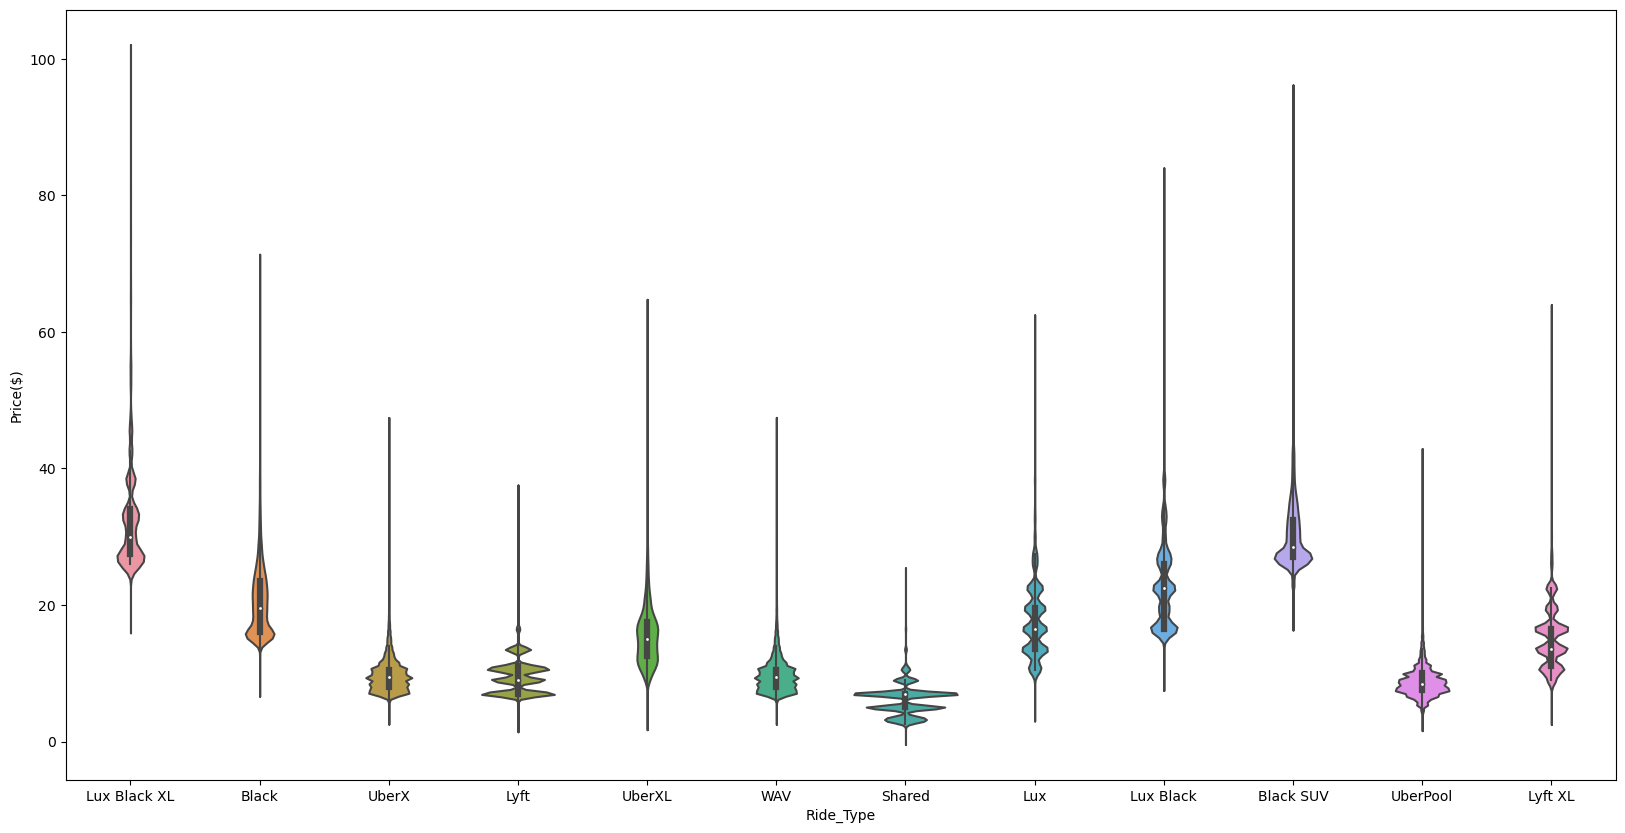

In [78]:
# Violin Plot for ride type vs Price
plt.figure(figsize=(20, 10))
sns.violinplot(data=final_df, x='Ride_Type', y='Price($)', gridsize=100, cut=10)

5.what is the relationships between distance and different ride types? 

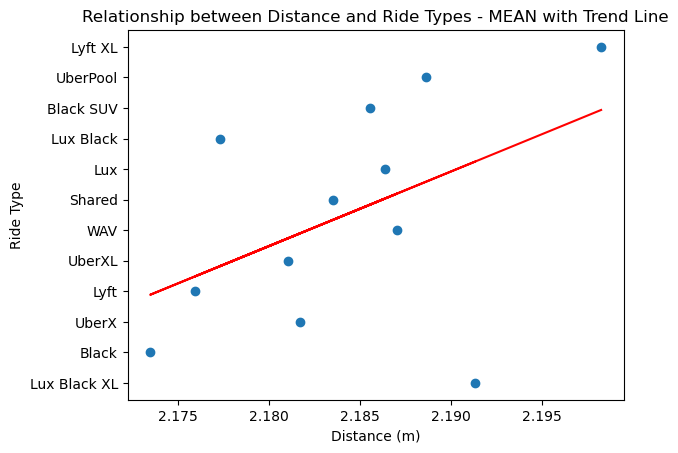

RIDE TYPE: MEAN DISTANCE
Lyft XL: 2.1982362362362364
Lux Black XL: 2.1912993788819874
UberPool: 2.188624548200228
WAV: 2.187021150318334
Lux: 2.186385775862069
Black SUV: 2.1855161548464537
Shared: 2.18352231280841
UberX: 2.181708813085118
UberXL: 2.1810269659292754
Lux Black: 2.1772834744276914
Lyft: 2.1759399718279337
Black: 2.173469093440748


In [79]:
# Calculate the mean distance for each ride type
ride_types = final_df["Ride_Type"].unique()
mean_distances = final_df.groupby("Ride_Type")["Distance(m)"].mean()

# Convert ride_types to numerical values
ride_type_values = np.arange(len(ride_types))

# Plot the scatter plot
plt.scatter(mean_distances, ride_type_values)
plt.xlabel("Distance (m)")
plt.ylabel("Ride Type")
plt.title("Relationship between Distance and Ride Types - MEAN with Trend Line")

# Set the y-axis tick labels to be the car type labels
plt.yticks(ride_type_values, ride_types)

# Add a trend line
slope, intercept = np.polyfit(mean_distances, ride_type_values, 1)
trend_line = slope * mean_distances + intercept
plt.plot(mean_distances, trend_line, color='r')

plt.show()

# Print the list of ride types with their mean distances in descending order
ride_type_mean_distances = list(zip(ride_types, mean_distances))
sorted_ride_type_mean_distances = sorted(ride_type_mean_distances, key=lambda x: x[1], reverse=True)

print("RIDE TYPE: MEAN DISTANCE")
for ride_type, mean_distance in sorted_ride_type_mean_distances:
    print(f"{ride_type}: {mean_distance}")

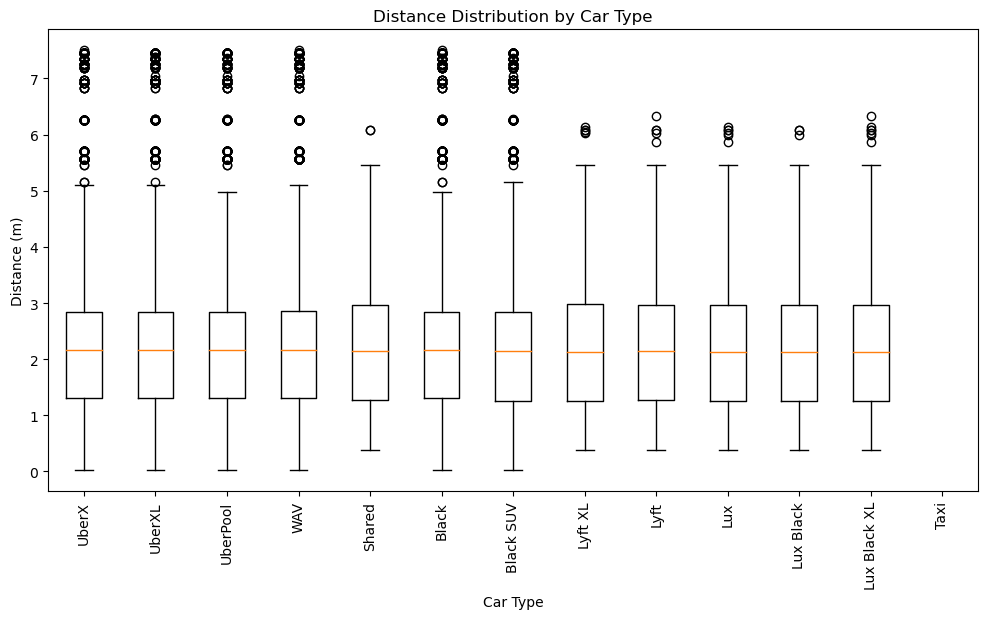

In [80]:
# 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2: Collect distances for each unique car type
car_type_distances = []
for car_type in unique_car_types:
    distances = final_df.loc[final_df['Ride_Type'] == car_type, 'Distance(m)']
    car_type_distances.append(distances)

# 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_distances, labels=unique_car_types)
plt.title('Distance Distribution by Car Type')
plt.xlabel('Car Type')
plt.ylabel('Distance (m)')
plt.xticks(rotation=90)
plt.show()

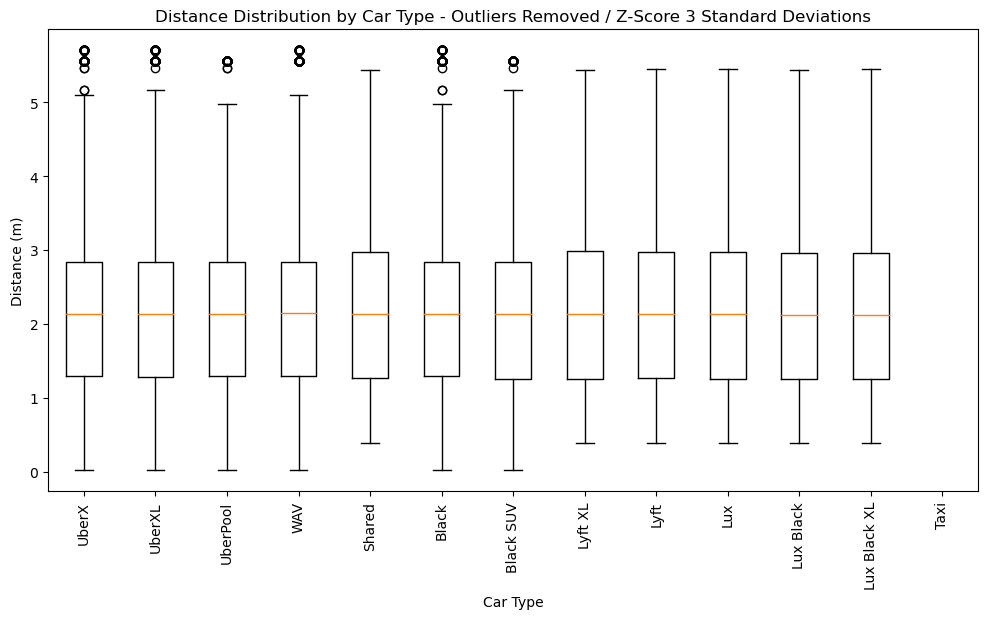

In [81]:
# Distance Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations
# 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2: Collect distances for each unique car type
car_type_distances = []
for car_type in unique_car_types:
    distances = final_df.loc[final_df['Ride_Type'] == car_type, 'Distance(m)']
    
    # Calculate Z-score for each distance
    z_scores = (distances - np.mean(distances)) / np.std(distances)
    
    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3
    
    # Remove outliers based on the Z-score method
    filtered_distances = distances[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Store the filtered distances in the list
    car_type_distances.append(filtered_distances)

# 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_distances, labels=unique_car_types)
plt.title('Distance Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Car Type')
plt.ylabel('Distance (m)')
plt.xticks(rotation=90)
plt.show()

5.A what is the relationship between distance and price?, ride types with price?, and pick up location with price? 

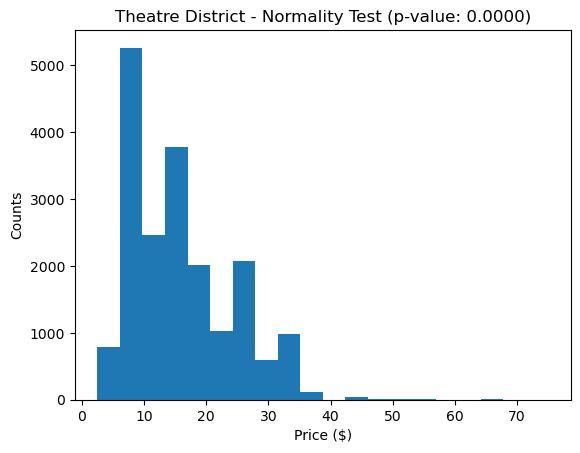

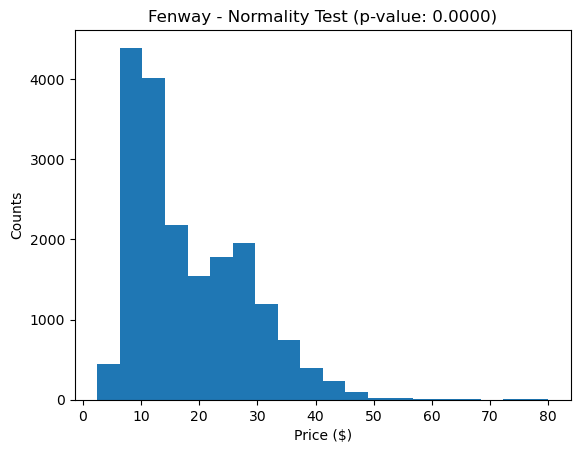

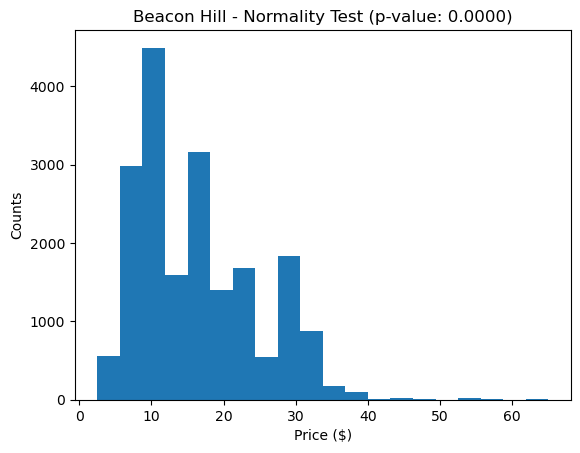

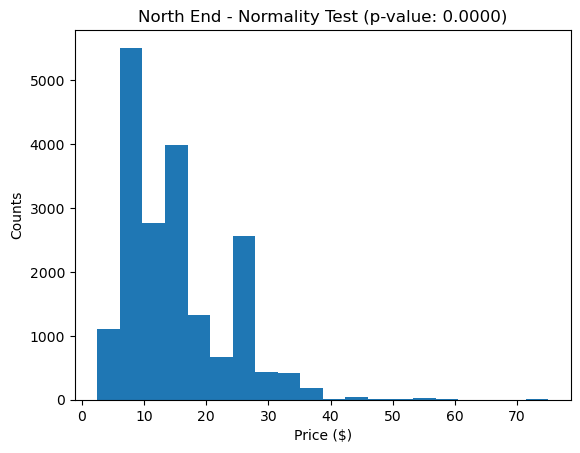

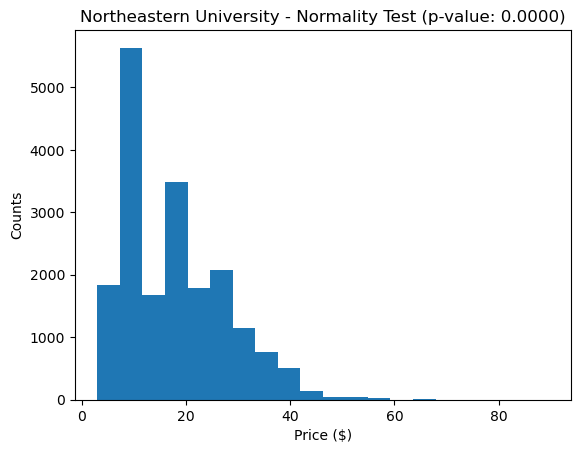

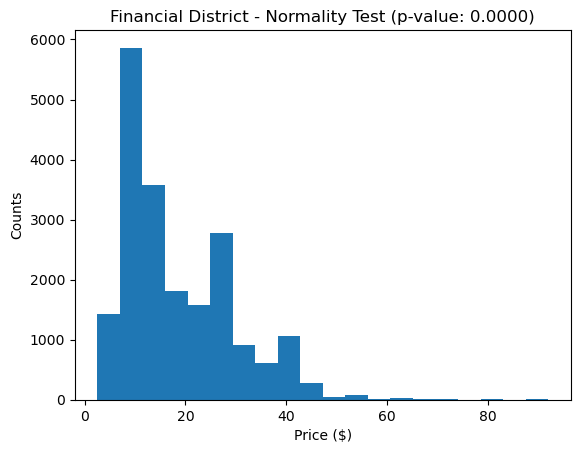

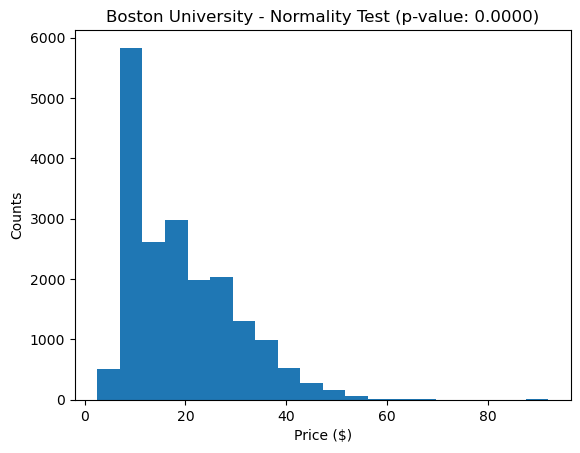

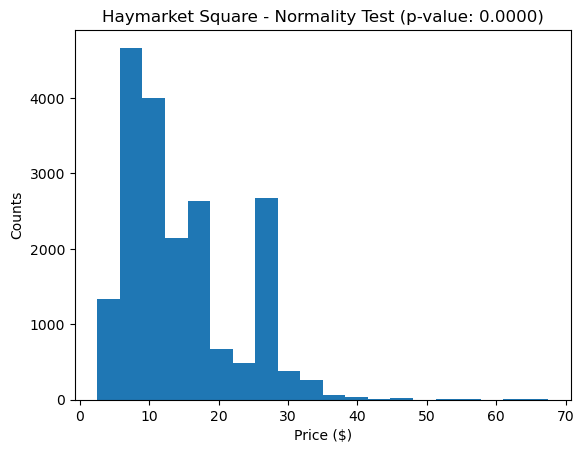

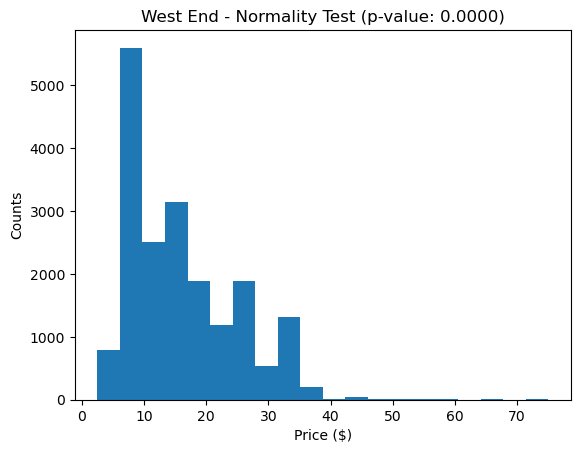

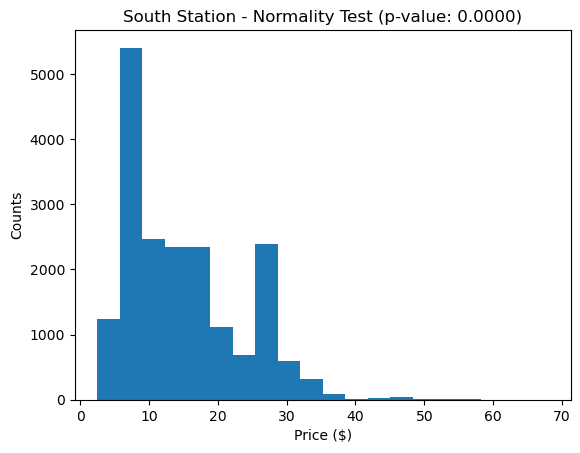

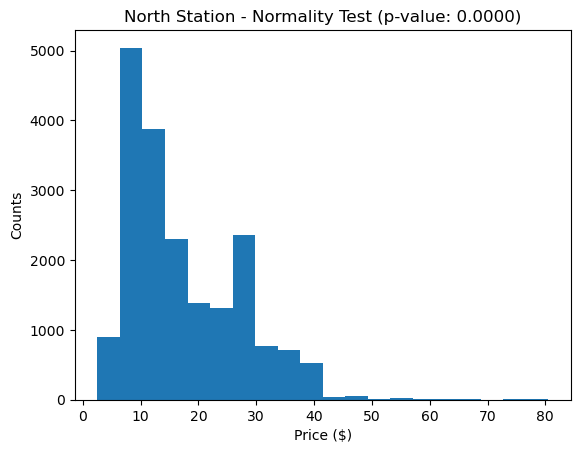

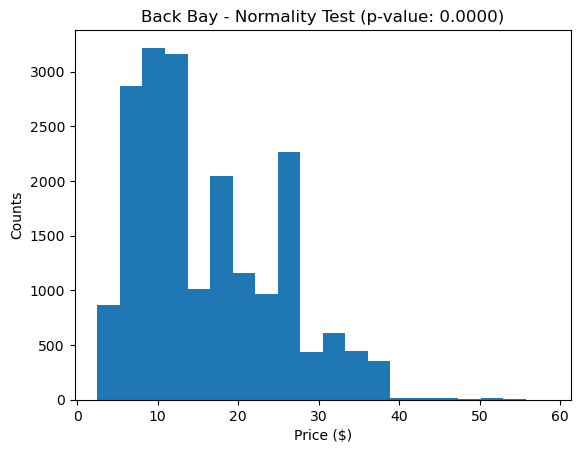

In [82]:
# NORMALTEST HISTOGRAMS for DESTINATION-to-PRICE relationship, look for BELL CURVE

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unique destinations
unique_destinations = final_df['Destination'].unique()

# Perform normality test and create histograms for each destination
for destination in unique_destinations:
    # Filter dataframe for the current destination
    filtered_df = final_df[final_df['Destination'] == destination]
    
    # Perform normality test on price column
    _, p_value = stats.normaltest(filtered_df['Price($)'])
    
    # Create histogram
    plt.hist(filtered_df['Price($)'], bins=20)
    plt.title(f'{destination} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Price ($)')
    plt.ylabel('Counts')
    plt.show()

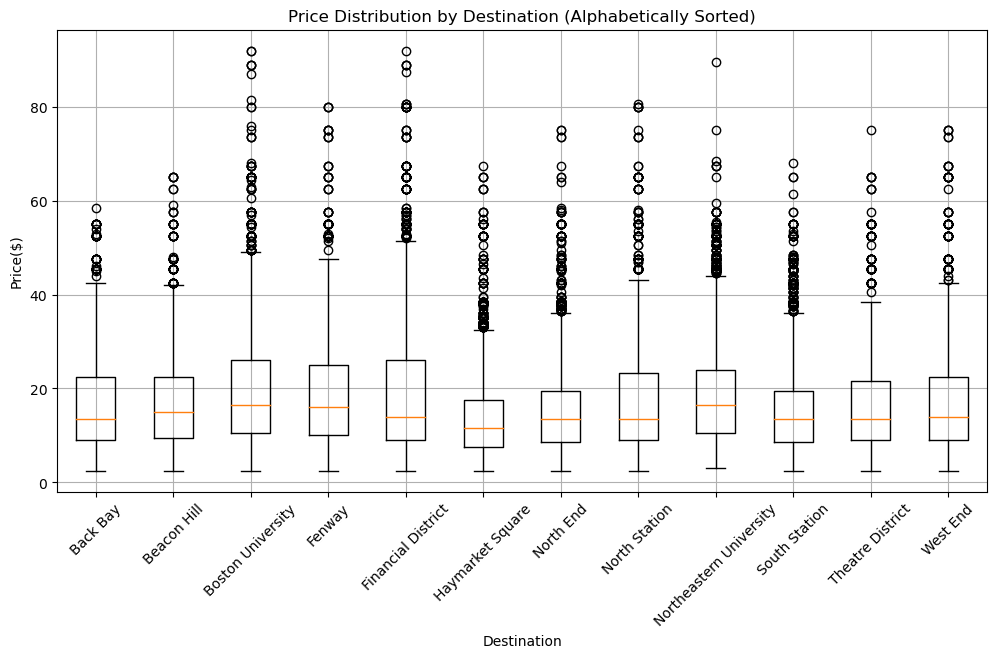

In [83]:
# Price Distribution by Destination (Alphabetically Sorted)

# Extract destination locations and sort alphabetically
destinations = sorted(final_df["Destination"].unique())

# Create a dictionary to store destination prices
destination_prices = {}

# Iterate over each destination
for destination in destinations:
    # Filter rows for the current destination
    destination_data = final_df[final_df["Destination"] == destination]
    # Get the prices for the current destination
    prices = destination_data["Price($)"].values
    # Store the prices in the dictionary
    destination_prices[destination] = prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(destination_prices.values())
plt.xticks(range(1, len(destinations) + 1), destinations, rotation=45)
plt.xlabel("Destination")
plt.ylabel("Price($)")
plt.title("Price Distribution by Destination (Alphabetically Sorted)")
plt.grid(True)

# Display the plot
plt.show()

In [84]:
# Price Distribution by Destination (Alphabetically Sorted) - Z-SCORE, Outliers removed

# Extract destination locations and sort alphabetically
destinations = sorted(final_df["Destination"].unique())

# Create a dictionary to store destination prices
destination_prices = {}

# Iterate over each destination
for destination in destinations:
    # Filter rows for the current destination
    destination_data = final_df[final_df["Destination"] == destination]
    # Get the prices for the current destination
    prices = destination_data["Price($)"].values
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Store the filtered prices in the dictionary
    destination_prices[destination] = filtered_prices

# Calculate and sort the median prices in descending order
median_prices = {destination: np.median(prices) for destination, prices in destination_prices.items()}
sorted_median_prices = sorted(median_prices.items(), key=lambda x: x[1], reverse=True)

# Print the sorted median prices
for destination, median_price in sorted_median_prices:
    print(f"Median price for {destination}: {median_price}")

Median price for Boston University: 16.5
Median price for Northeastern University: 16.5
Median price for Fenway: 16.0
Median price for Beacon Hill: 15.0
Median price for Financial District: 14.0
Median price for Back Bay: 13.5
Median price for North End: 13.5
Median price for North Station: 13.5
Median price for South Station: 13.5
Median price for Theatre District: 13.5
Median price for West End: 13.5
Median price for Haymarket Square: 11.5


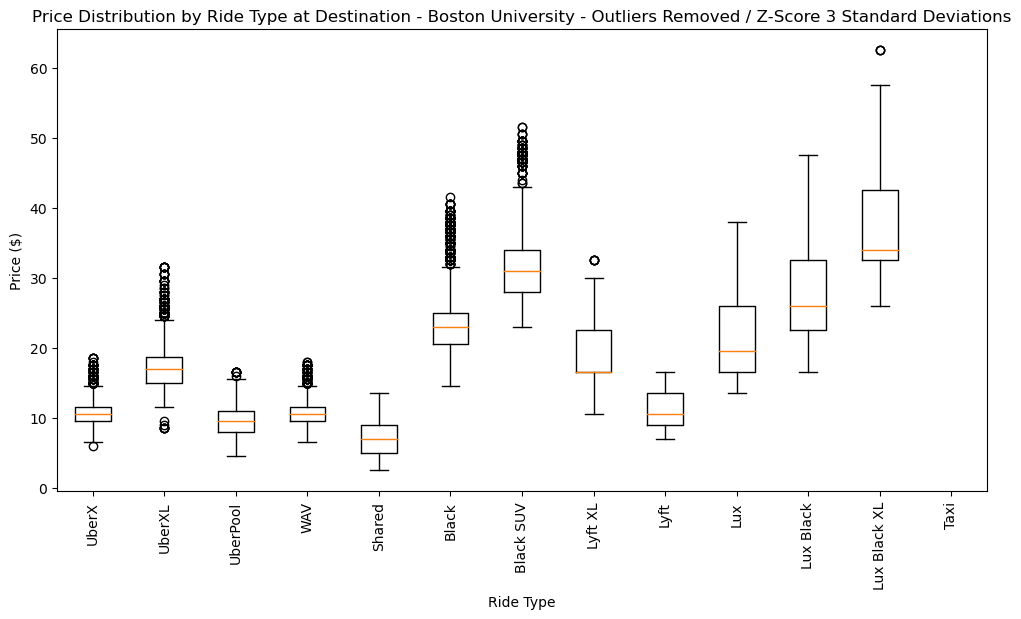

In [85]:
# Price Distribution by Ride Type at Boston University, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Boston University destination and collect prices for each unique ride type
ride_type_prices = []
for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Destination'] == 'Boston University') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Boston University
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type at Destination - Boston University - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

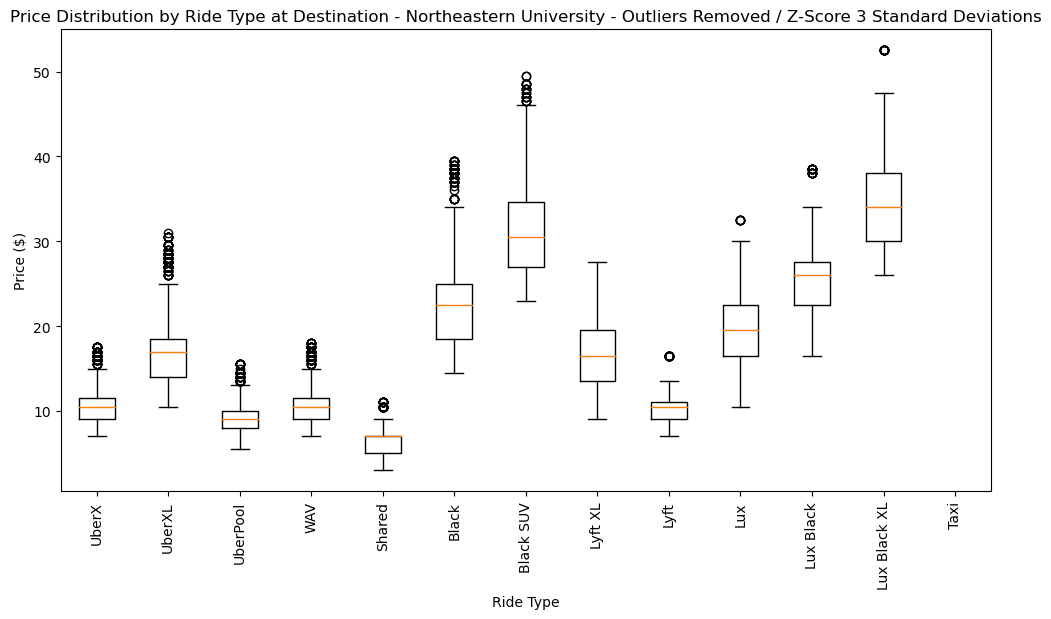

In [86]:
# Price Distribution by Ride Type at Northeastern University, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Northeastern University destination and collect prices for each unique ride type
ride_type_prices = []
for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Destination'] == 'Northeastern University') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Noortheastern University
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type at Destination - Northeastern University - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

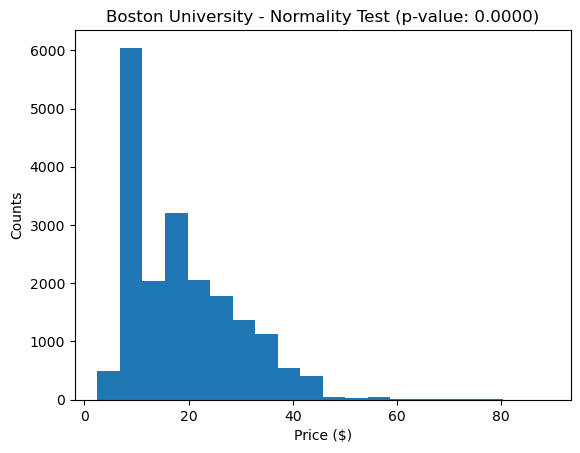

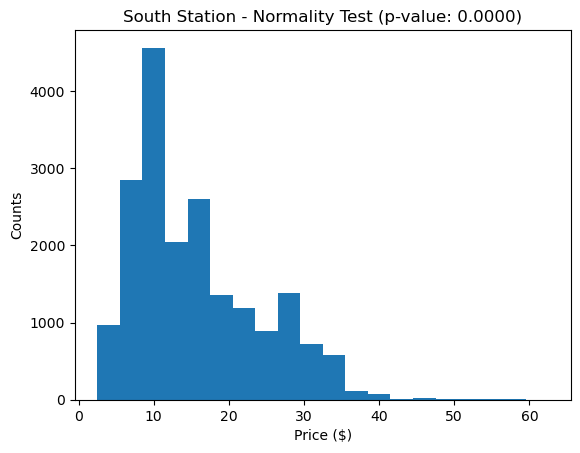

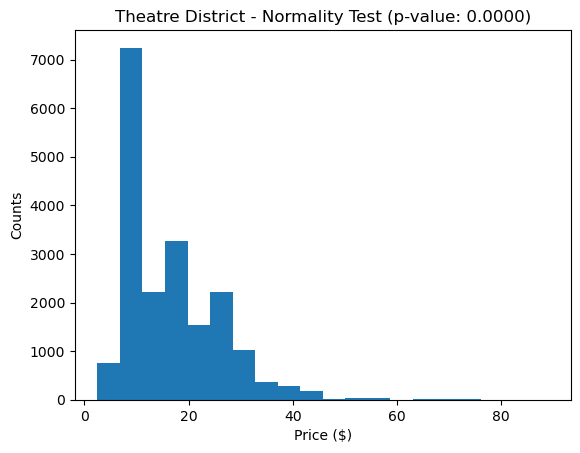

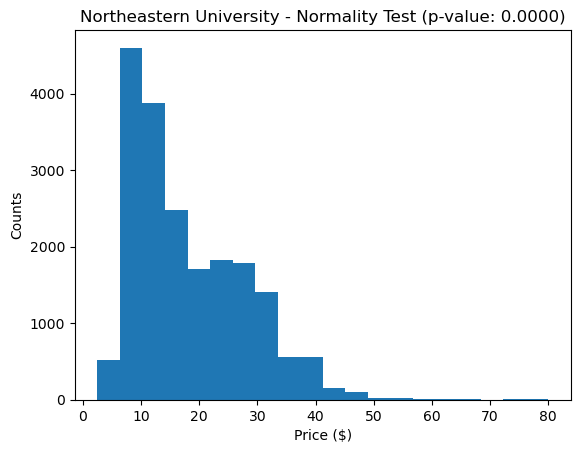

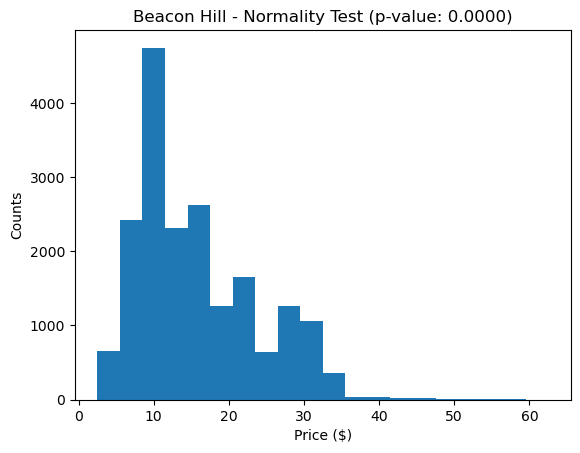

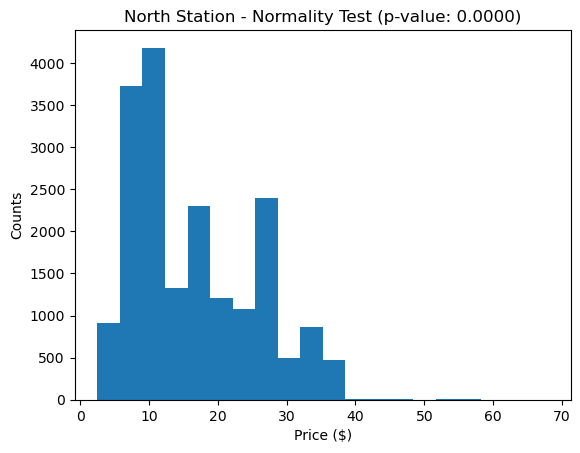

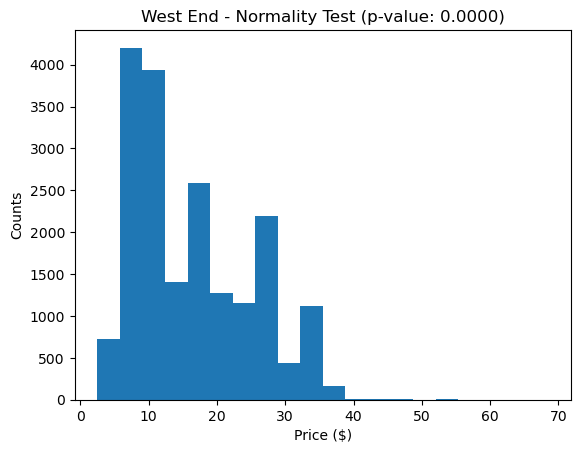

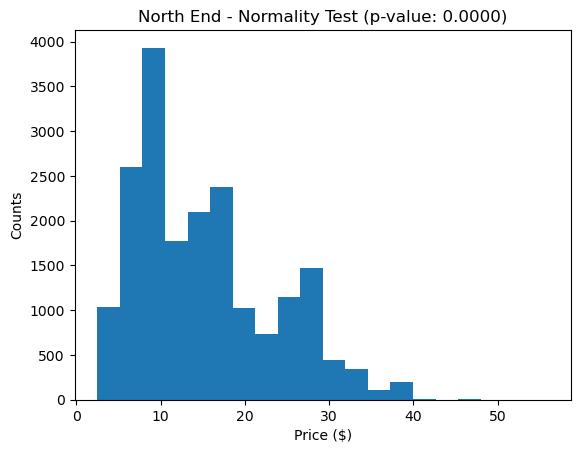

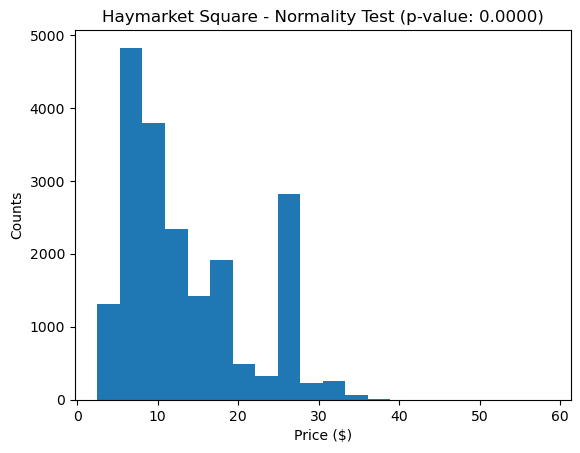

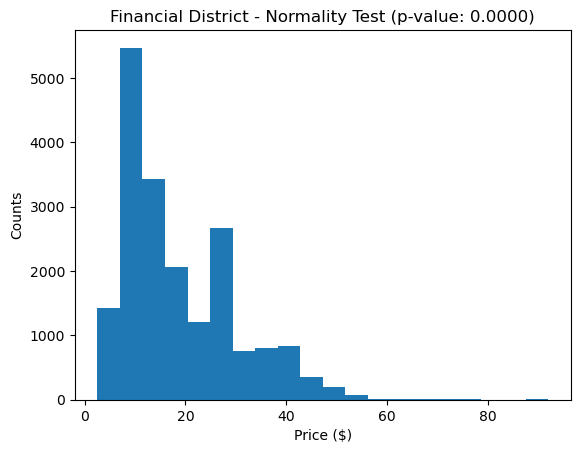

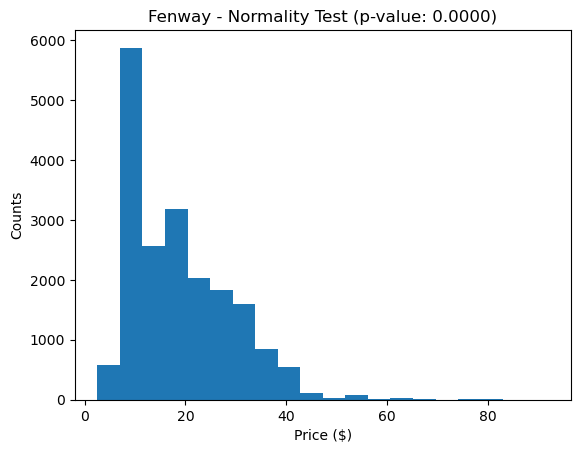

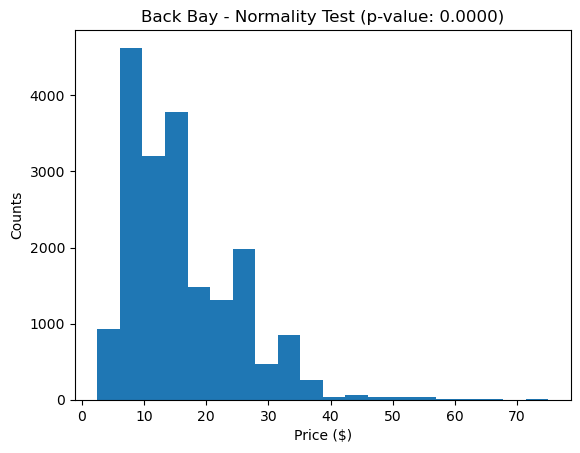

In [87]:
# NORMALTEST HISTOGRAMS for PICK_UP_LOCATION-to-PRICE relationship, look for BELL CURVE

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unique pick-up locations
unique_pickup_locations = final_df['Pick_Up_Location'].unique()

# Perform normality test and create histograms for each pick-up location
for pickup_location in unique_pickup_locations:
    # Filter dataframe for the current pick-up location
    filtered_df = final_df[final_df['Pick_Up_Location'] == pickup_location]
    
    # Perform normality test on price column
    _, p_value = stats.normaltest(filtered_df['Price($)'])
    
    # Create histogram
    plt.hist(filtered_df['Price($)'], bins=20)
    plt.title(f'{pickup_location} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Price ($)')
    plt.ylabel('Counts')
    plt.show()

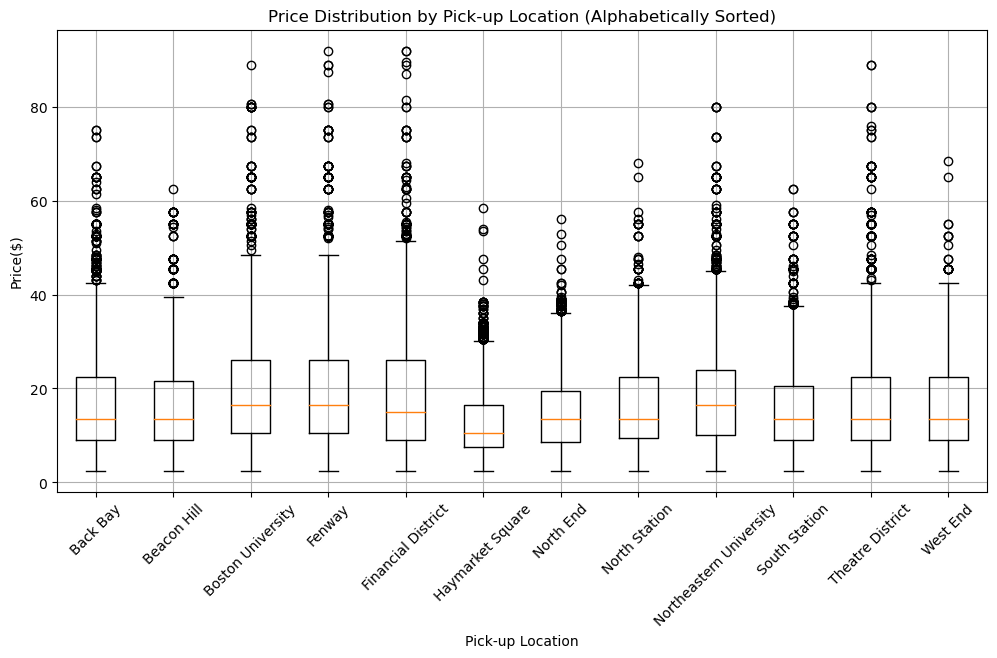

In [88]:
# Price Distribution by Pick-up Location (Alphabetically Sorted)
# Extract pick-up locations and sort alphabetically
pickup_locations = sorted(final_df["Pick_Up_Location"].unique())

# Create a dictionary to store pick-up location prices
pickup_prices = {}

# Iterate over each pick-up location
for pickup_location in pickup_locations:
    # Filter rows for the current pick-up location
    pickup_data = final_df[final_df["Pick_Up_Location"] == pickup_location]
    # Get the prices for the current pick-up location
    prices = pickup_data["Price($)"].values
    # Store the prices in the dictionary
    pickup_prices[pickup_location] = prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(pickup_prices.values())
plt.xticks(range(1, len(pickup_locations) + 1), pickup_locations, rotation=45)
plt.xlabel("Pick-up Location")
plt.ylabel("Price($)")
plt.title("Price Distribution by Pick-up Location (Alphabetically Sorted)")
plt.grid(True)

# Display the plot
plt.show()

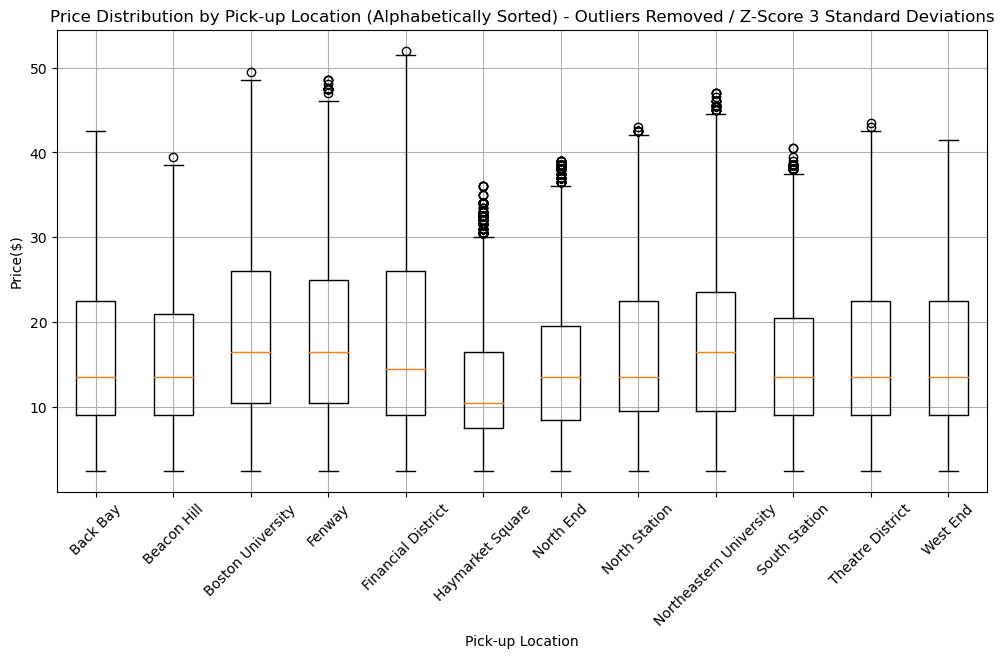

Median price for Boston University: 16.5
Median price for Fenway: 16.5
Median price for Northeastern University: 16.5
Median price for Financial District: 14.5
Median price for Back Bay: 13.5
Median price for Beacon Hill: 13.5
Median price for North End: 13.5
Median price for North Station: 13.5
Median price for South Station: 13.5
Median price for Theatre District: 13.5
Median price for West End: 13.5
Median price for Haymarket Square: 10.5


In [89]:
# Price Distribution by PICK_UP_LOCATION (Alphabetically Sorted) - Z-SCORE, Outliers removed

# Extract pick-up locations and sort alphabetically
pickup_locations = sorted(final_df["Pick_Up_Location"].unique())

# Create a dictionary to store pick-up location prices
pickup_prices = {}

# Iterate over each pick-up location
for pickup_location in pickup_locations:
    # Filter rows for the current pick-up location
    pickup_data = final_df[final_df["Pick_Up_Location"] == pickup_location]
    # Get the prices for the current pick-up location
    prices = pickup_data["Price($)"].values
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Store the filtered prices in the dictionary
    pickup_prices[pickup_location] = filtered_prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(pickup_prices.values())
plt.xticks(range(1, len(pickup_locations) + 1), pickup_locations, rotation=45)
plt.xlabel("Pick-up Location")
plt.ylabel("Price($)")
plt.title("Price Distribution by Pick-up Location (Alphabetically Sorted) - Outliers Removed / Z-Score 3 Standard Deviations")
plt.grid(True)

# Display the plot
plt.show()

# Calculate and print the sorted median prices
median_prices = {pickup_location: np.median(prices) for pickup_location, prices in pickup_prices.items()}
sorted_median_prices = sorted(median_prices.items(), key=lambda x: x[1], reverse=True)

# Print the sorted median prices
for pickup_location, median_price in sorted_median_prices:
    print(f"Median price for {pickup_location}: {median_price}")

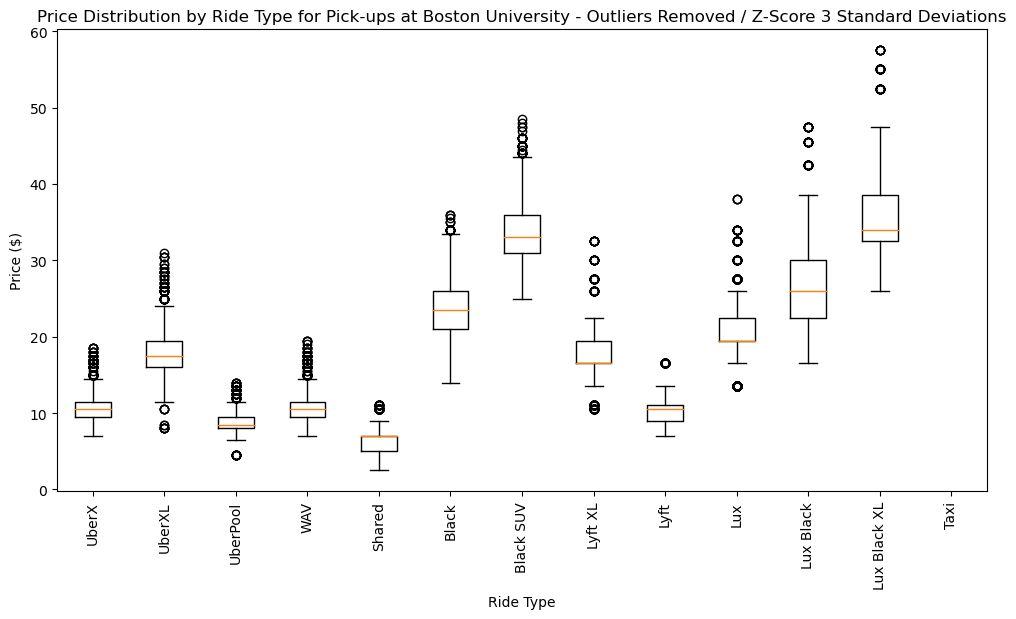

In [90]:
# Price Distribution by Ride Type for Pick-ups at Boston University, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Boston University pick-up location and collect prices for each unique ride type
ride_type_prices = []
for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Pick_Up_Location'] == 'Boston University') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Boston University as the pick-up location
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type for Pick-ups at Boston University - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

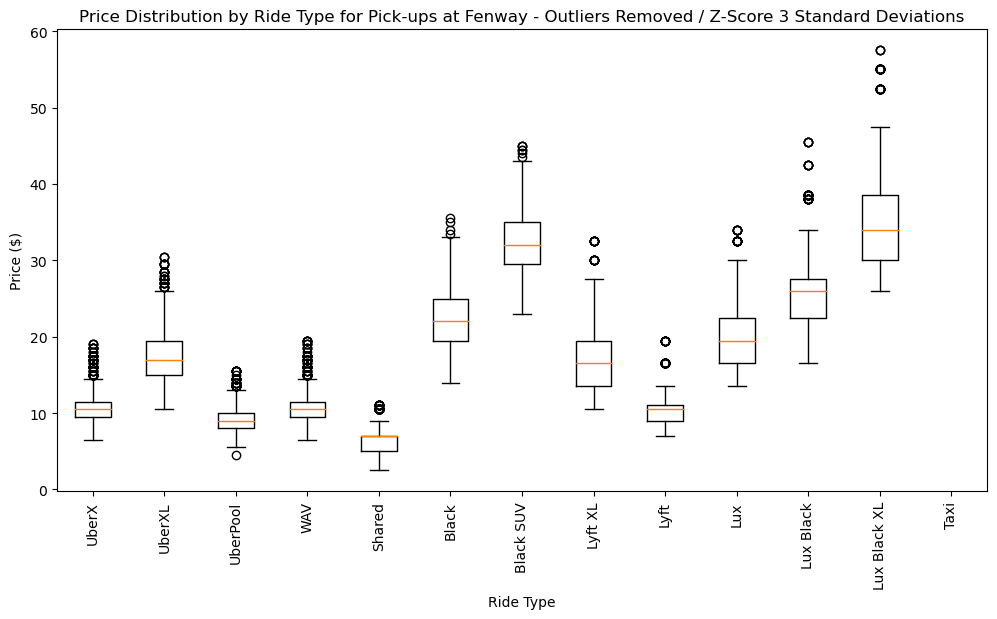

In [91]:
# Price Distribution by Ride Type for Pick-ups at Fenway, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Fenway pick-up location and collect prices for each unique ride type
ride_type_prices = []
for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Pick_Up_Location'] == 'Fenway') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Fenway as the pick-up location
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type for Pick-ups at Fenway - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

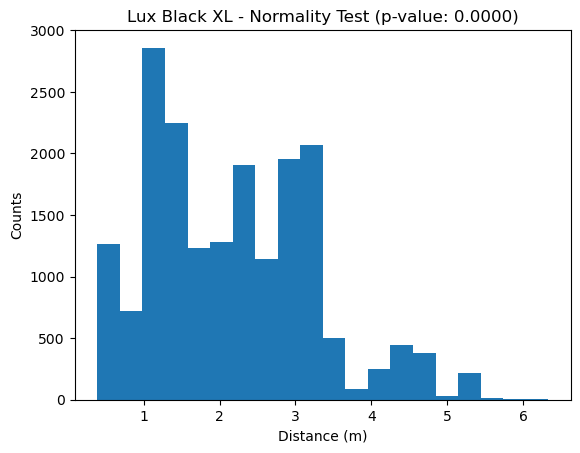

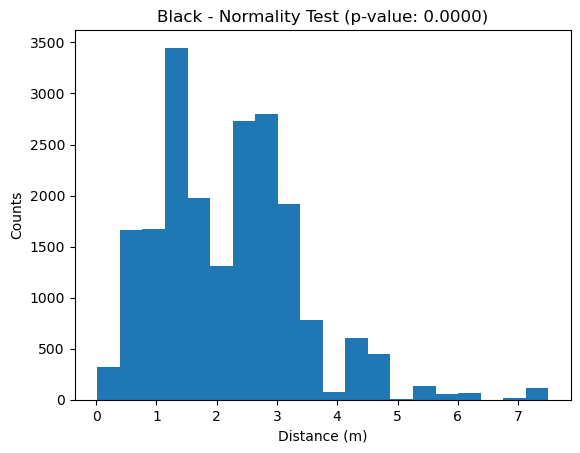

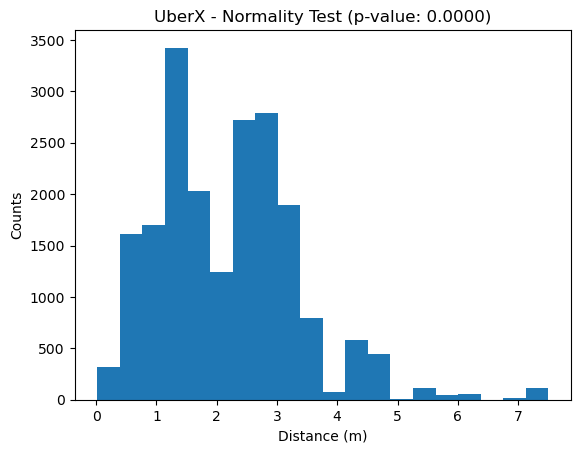

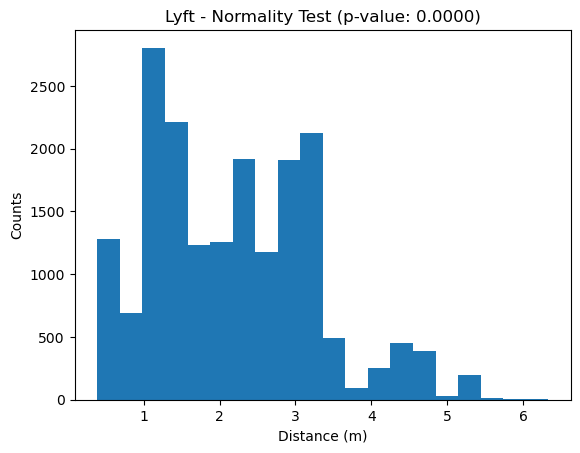

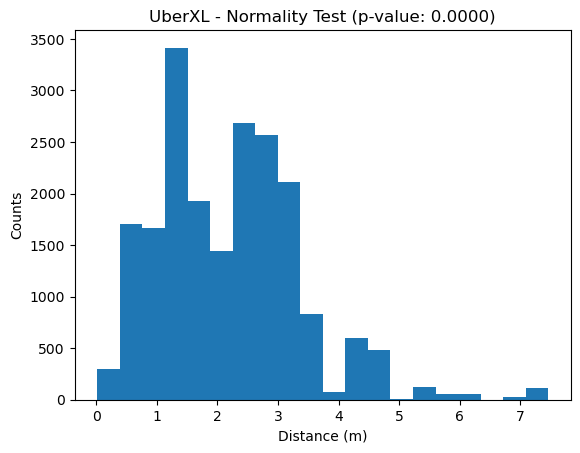

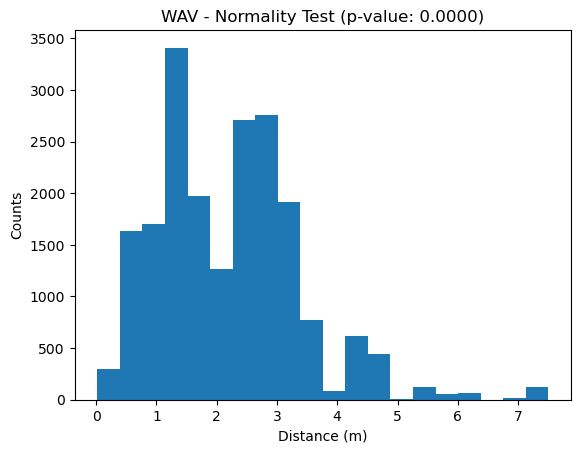

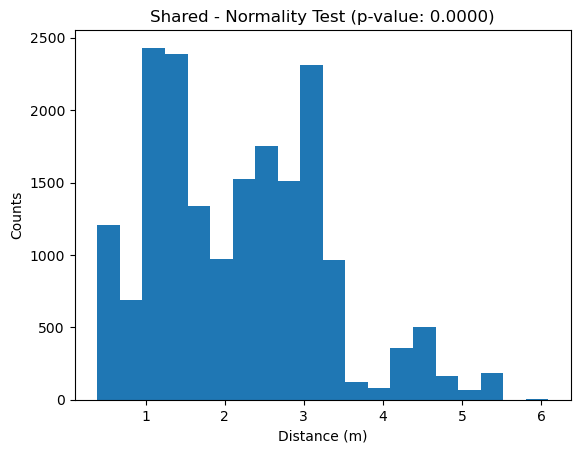

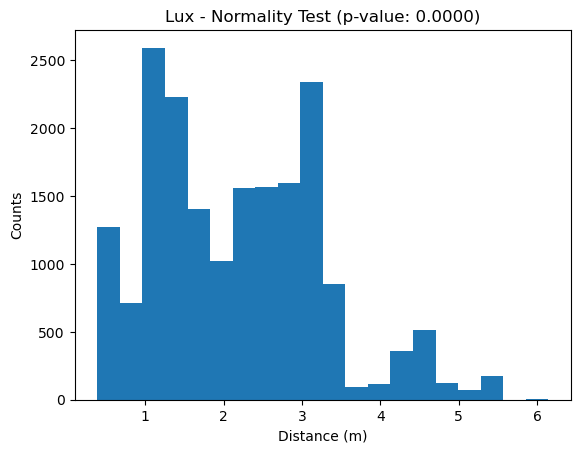

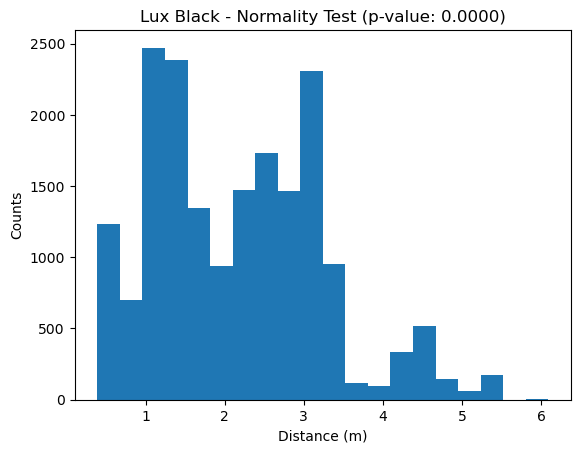

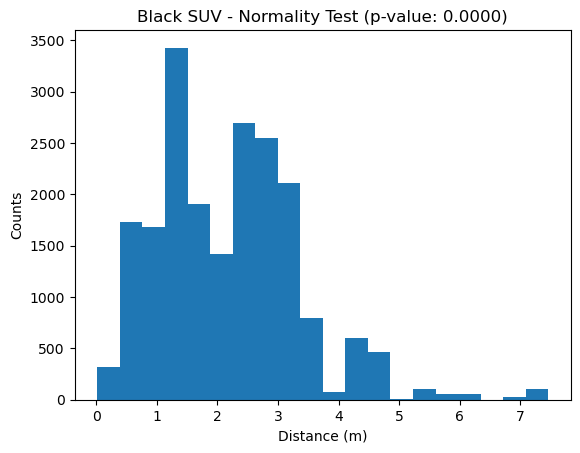

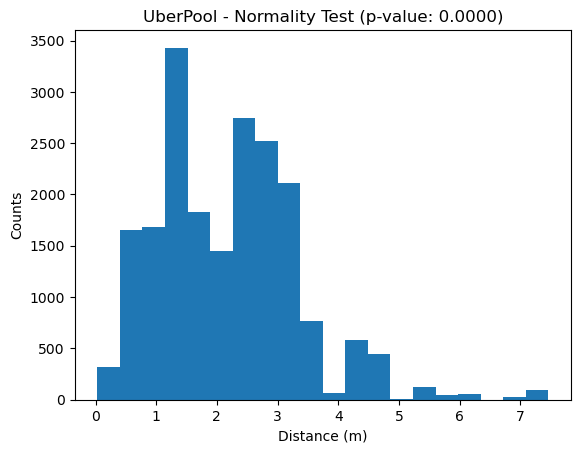

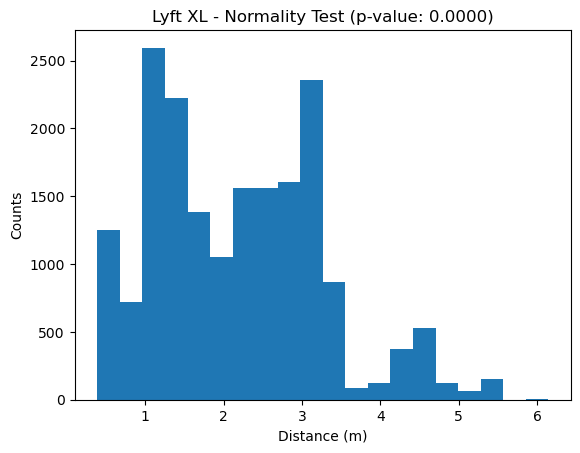

In [92]:
# NORMALTEST HISTOGRAMS for RIDE_TYPE-to-DISTANCE relationship, look for BELL CURVE


# Unique ride types
unique_ride_types = final_df['Ride_Type'].unique()

# Perform normality test and create histograms for each ride type
for ride_type in unique_ride_types:
    # Filter dataframe for the current ride type
    filtered_df = final_df[final_df['Ride_Type'] == ride_type]
    
    # Perform normality test on distance column
    _, p_value = stats.normaltest(filtered_df['Distance(m)'])
    
    # Create histogram
    plt.hist(filtered_df['Distance(m)'], bins=20)
    plt.title(f'{ride_type} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Distance (m)')
    plt.ylabel('Counts')
    plt.show()

<Axes: xlabel='Destination', ylabel='Price($)'>

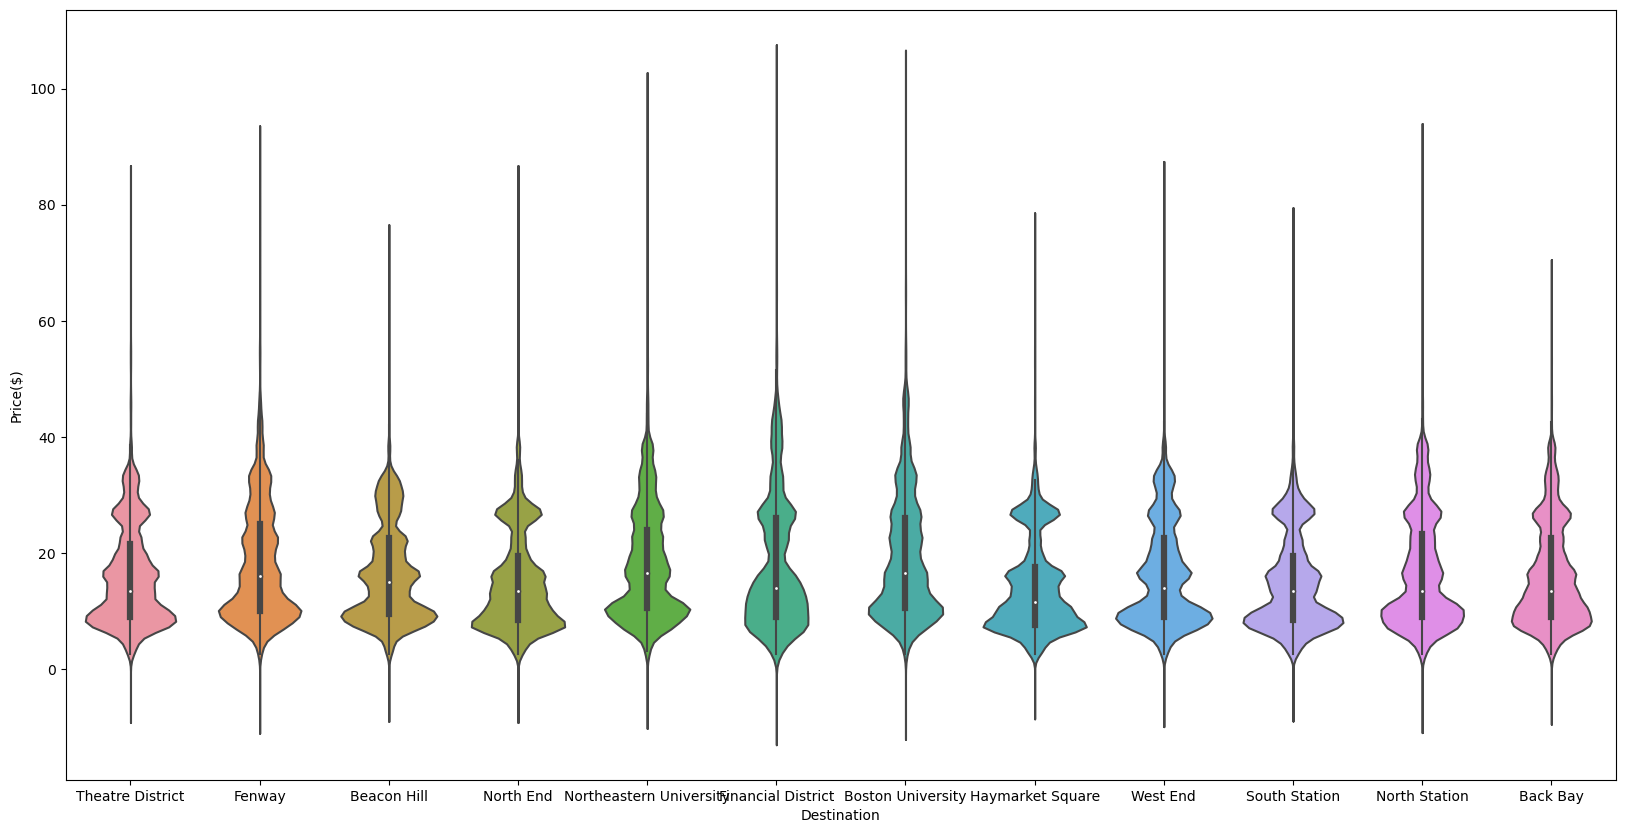

In [93]:
# Violin Plot for Destination vs Price
plt.figure(figsize=(20, 10))
sns.violinplot(data=final_df, x='Destination', y='Price($)', gridsize=100, cut=10)

6. What the hypothesis for Distance vs. Price for Each ride?
1- The problem: How do we know if Distance would effect the price charges on each app?
2- The solution: ANOVA - does Distance not effect the price that each ride charges?

<Axes: title={'center': 'Distance(m)'}, xlabel='Price($)'>

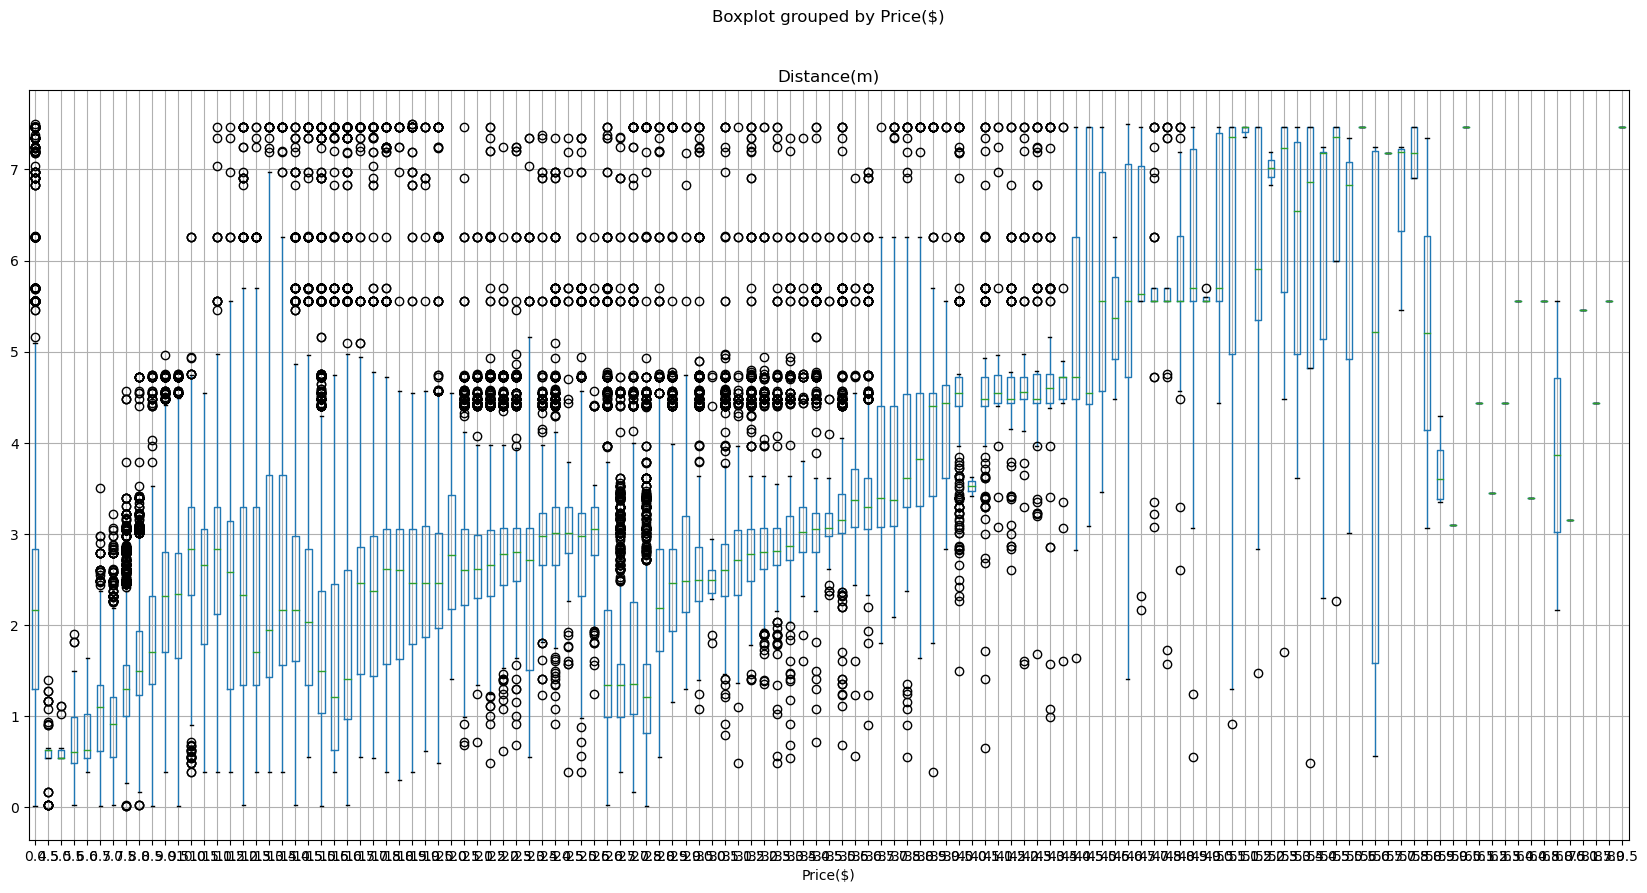

In [94]:
#Create BoxPlot to compare mean of the distance vs Price
#Uber
uber_rides.boxplot("Distance(m)", by="Price($)", figsize=(20, 10))

In [95]:
# Extract individual groups based on different price 
group0 = uber_rides[uber_rides["Price($)"] <= 30]["Distance(m)"]
group1 = uber_rides[uber_rides["Price($)"] <= 60]["Distance(m)"]
group2 = uber_rides[uber_rides["Price($)"] <= 90]["Distance(m)"]
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

F_onewayResult(statistic=253.84273239501016, pvalue=6.688972062947959e-111)

<Axes: title={'center': 'Distance(m)'}, xlabel='Price($)'>

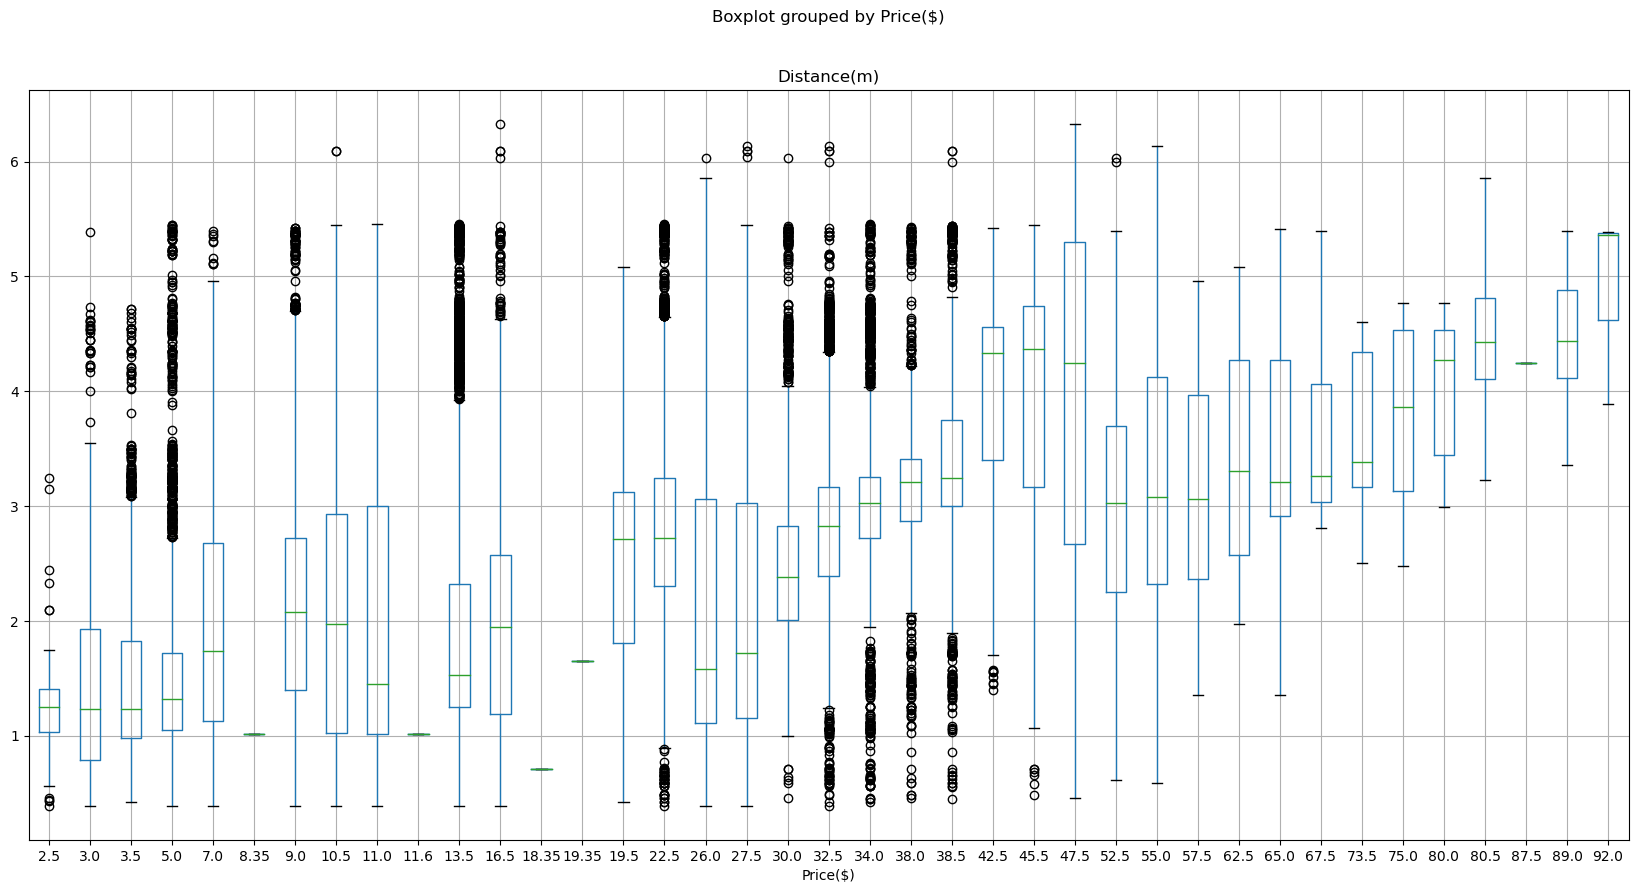

In [97]:
#Create BoxPlot to compare mean of the distance vs Price
#Lyft 
lyft_rides.boxplot("Distance(m)", by="Price($)", figsize=(20, 10))

In [98]:
# Extract individual groups based on different price 
group0 = lyft_rides[lyft_rides["Price($)"] <= 30]["Distance(m)"]
group1 = lyft_rides[lyft_rides["Price($)"] <= 60]["Distance(m)"]
group2 = lyft_rides[lyft_rides["Price($)"] <= 90]["Distance(m)"]
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

F_onewayResult(statistic=385.7138802399962, pvalue=4.858273627090331e-168)

6.A : what is the ride type patterns with price based on normality tests?

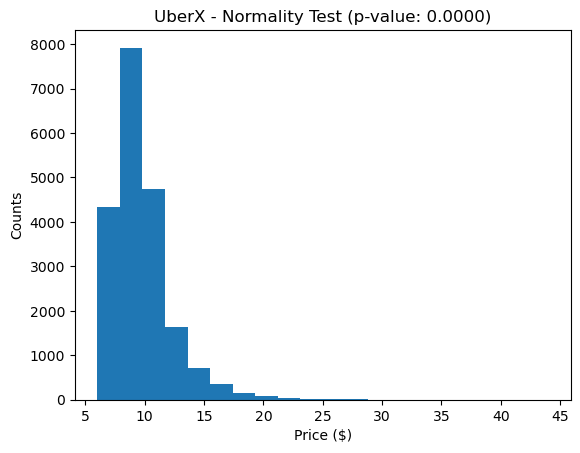

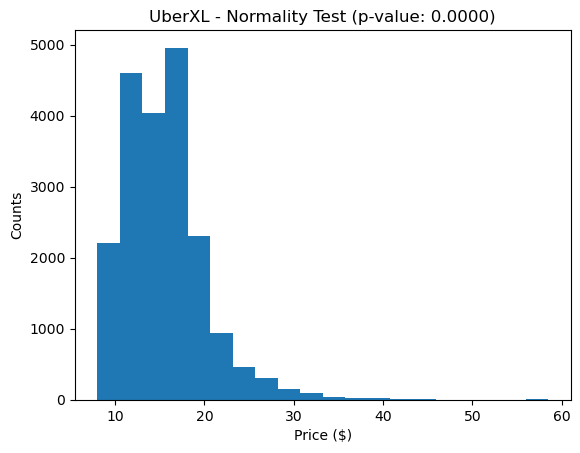

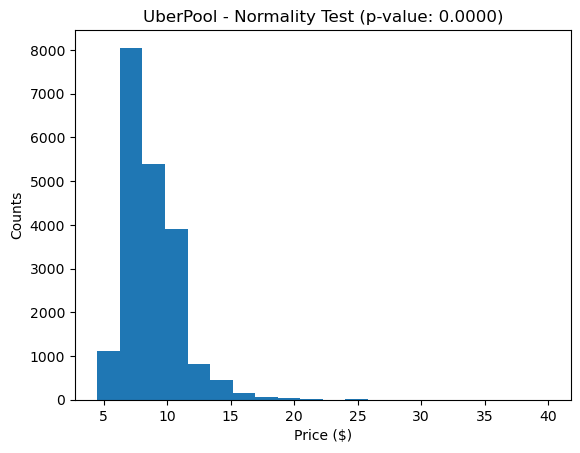

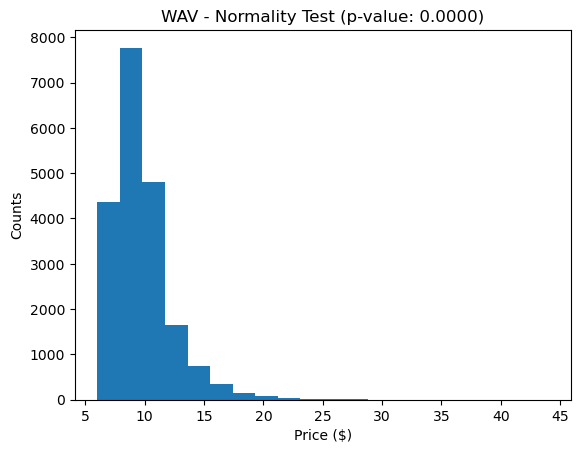

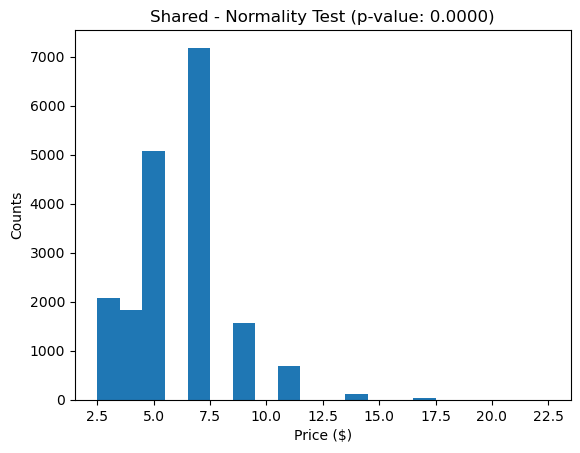

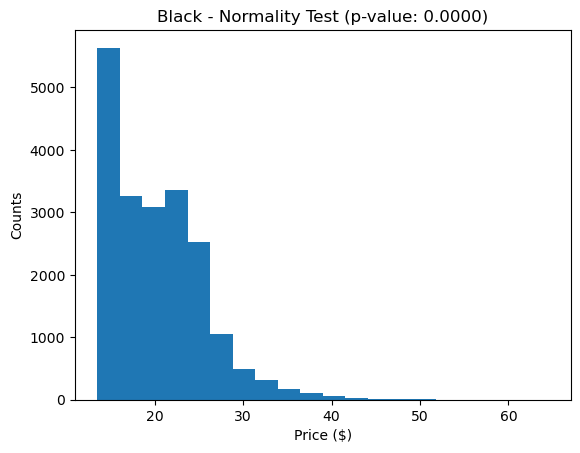

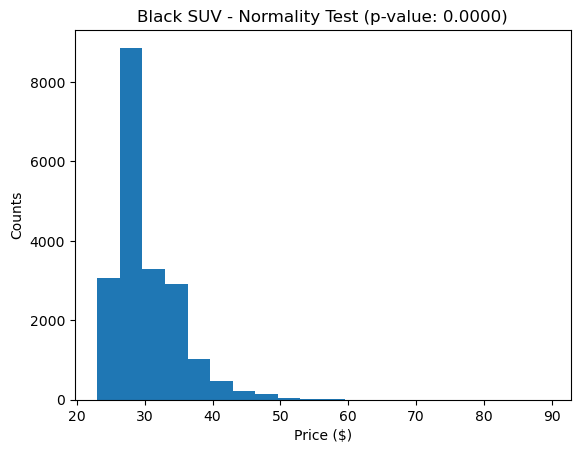

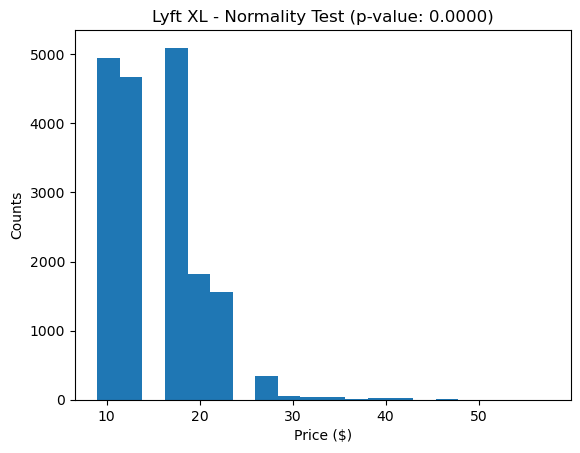

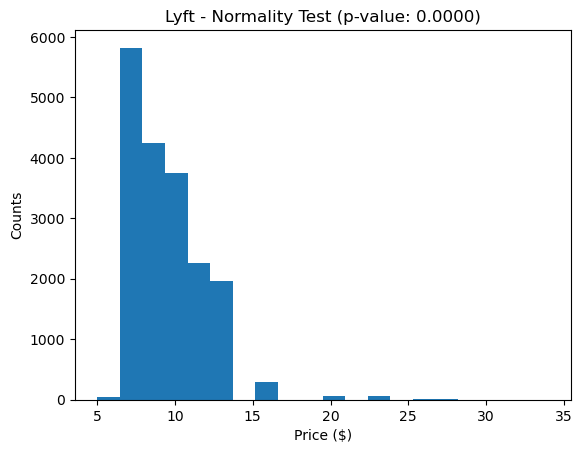

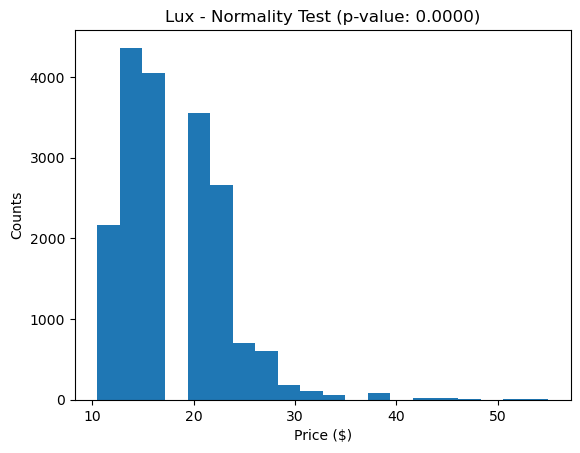

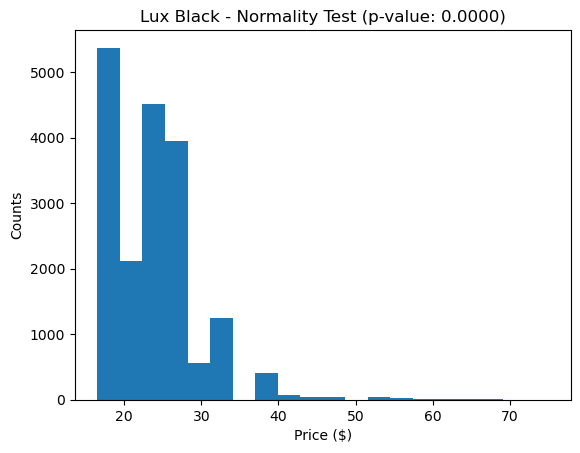

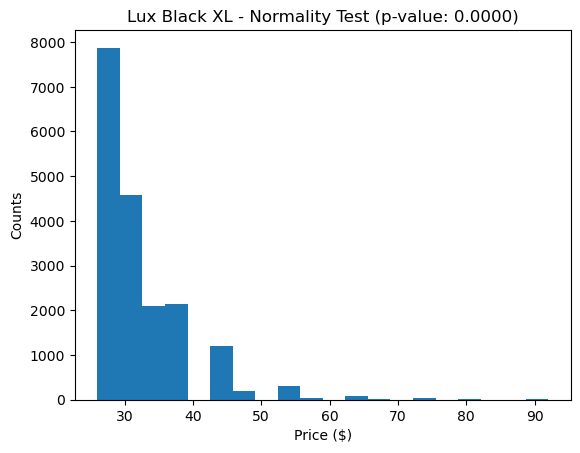

ValueError: skewtest is not valid with less than 8 samples; 0 samples were given.

In [99]:
# Unique car types
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Perform normality test and create histograms for each ride type
for car_type in unique_car_types:
    # Filter dataframe for the current ride type
    filtered_df = final_df[final_df['Ride_Type'] == car_type]
    
    # Perform normality test on price column
    _, p_value = st.normaltest(filtered_df['Price($)'])
    
    # Create histogram
    plt.hist(filtered_df['Price($)'], bins=20)
    plt.title(f'{car_type} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Price ($)')
    plt.ylabel('Counts')
    plt.show()

ANOVA testing 
What the hypothesis for destination vs. Price?, Ride_type vs.Price?, rideshare_app vs price?and 


In [100]:
group0 = final_df[final_df["Destination"] == 'Theatre District']["Price($)"]
group1 = final_df[final_df["Destination"] == 'West End']["Price($)"]
group2 = final_df[final_df["Destination"] == 'South Station']["Price($)"]
group3 = final_df[final_df["Destination"] == 'Northeastern University']["Price($)"]
group4 = final_df[final_df["Destination"] == 'North Station']["Price($)"]
group5 = final_df[final_df["Destination"] == 'North End']["Price($)"]
group6 = final_df[final_df["Destination"] == 'Haymarket Square']["Price($)"]
group7 = final_df[final_df["Destination"] == 'Financial District']["Price($)"]
group8 = final_df[final_df["Destination"] == 'Fenway']["Price($)"]
group9 = final_df[final_df["Destination"] == 'Boston University']["Price($)"]
group10 = final_df[final_df["Destination"] == 'Beacon Hill']["Price($)"]
group11 = final_df[final_df["Destination"] == 'Back Bay']["Price($)"]

st.f_oneway(group0, group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11)

F_onewayResult(statistic=477.30566126518863, pvalue=0.0)

In [101]:
#Anova Ride Type vs Price
AN0 = final_df[final_df["Ride_Type"] == 'Black']["Price($)"]
AN1 = final_df[final_df["Ride_Type"] == 'Black SUV']["Price($)"]
AN2 = final_df[final_df["Ride_Type"] == 'Lux']["Price($)"]
AN3 = final_df[final_df["Ride_Type"] == 'Lux Black']["Price($)"]
AN4 = final_df[final_df["Ride_Type"] == 'Lux Black XL']["Price($)"]
AN5 = final_df[final_df["Ride_Type"] == 'Lyft']["Price($)"]
AN6 = final_df[final_df["Ride_Type"] == 'Lyft XL']["Price($)"]
AN7 = final_df[final_df["Ride_Type"] == 'Shared']["Price($)"]
AN8 = final_df[final_df["Ride_Type"] == 'Taxi']["Price($)"]
AN9 = final_df[final_df["Ride_Type"] == 'UberPool']["Price($)"]
AN10 = final_df[final_df["Ride_Type"] == 'UberX']["Price($)"]
AN11 = final_df[final_df["Ride_Type"] == 'UberXL']["Price($)"]
AN12 = final_df[final_df["Ride_Type"] == 'WAV']["Price($)"]

st.f_oneway(AN0, AN1, AN2, AN3, AN4, AN5, AN6, AN7, AN8, AN9, AN10, AN11,AN12)

F_onewayResult(statistic=nan, pvalue=nan)

In [102]:
#Anova for Rideshare app vs Price
AN0_rideapp = final_df[final_df["Rideshare_App"] == 'Lyft']["Price($)"]
AN1_rideapp = final_df[final_df["Rideshare_App"] == 'Uber']["Price($)"]

stats.f_oneway(AN0_rideapp, AN1_rideapp)

F_onewayResult(statistic=1564.9544767952284, pvalue=0.0)

Text(0.5, 1.0, 'Shared Rides wrt Time of Day')

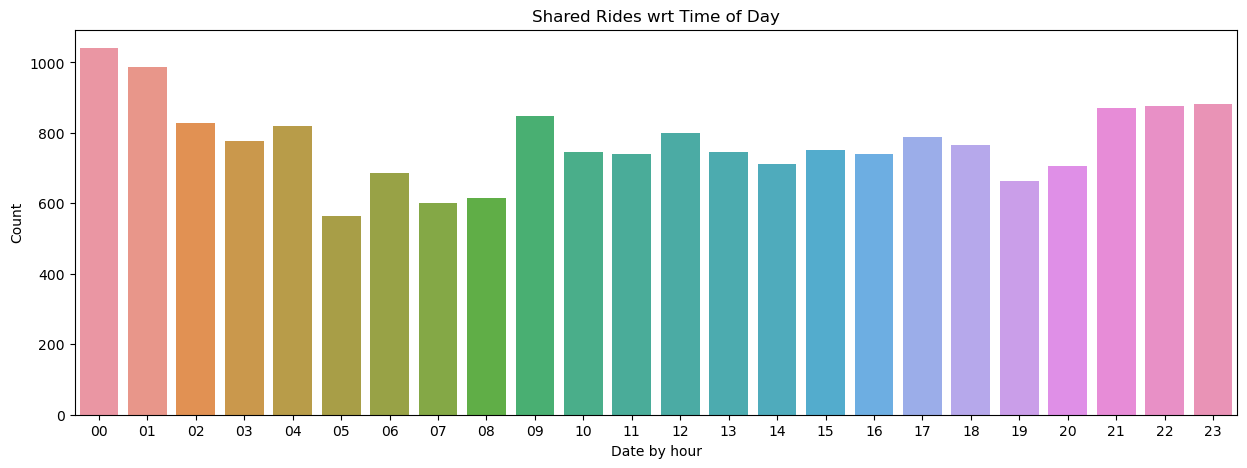

In [103]:
#Analysis on Shared rides with respect to time of the day.
final_df["Ride_Type"].value_counts()
lyft_shared_rides_df = final_df[final_df["Ride_Type"] == "Shared"]
lyft_shared_ride_td = lyft_shared_rides_df.groupby(["Ride_Type", "Date by hour"]).size().reset_index()
lyft_shared_ride_td.columns = ["Ride_Type", "Date by hour", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(x="Date by hour", y="Count", data = lyft_shared_ride_td).set_title("Shared Rides wrt Time of Day")